<div align = "center">

# **Modelación de Frecuencia**

</div>

## Fase 1: Configuración y Carga de Datos

In [13]:
# Configuración de librerías para análisis de frecuencias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo seaborn
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

# Paleta de colores consistente para los 3 amparos
# (DISPOSICIONES LEGALES fue combinado con CUMPLIMIENTO por baja credibilidad)
COLORES_AMPARO = sns.color_palette("Set2", n_colors=3)

print("✓ Librerías configuradas")

✓ Librerías configuradas


In [14]:
# Cargar base clustered
df = pd.read_csv('../data/tmp/base_final_anual_clustered.csv', low_memory=False)

print("=" * 70)
print("CARGA DE DATOS - BASE FINAL CLUSTERED")
print("=" * 70)
print(f"\nDimensiones: {df.shape[0]:,} registros × {df.shape[1]} columnas")
print(f"\nColumnas disponibles:")
for col in df.columns:
    print(f"  • {col}: {df[col].dtype}")

print(f"\n{'─'*70}")
print("Unidad de observación: PERÍODO-PÓLIZA-AMPARO")
print(f"  → Cada registro representa un año de exposición de una póliza")
print(f"  → Variable respuesta: TUVO_SINIESTRO (0/1)")
print(f"{'─'*70}")

CARGA DE DATOS - BASE FINAL CLUSTERED

Dimensiones: 738,902 registros × 22 columnas

Columnas disponibles:
  • ID_POLIZA_AMPARO_PERIODO: object
  • POLIZA: int64
  • AMPARO: object
  • ANIO_POLIZA: int64
  • PERIODO: int64
  • VIGENCIA_PERIODO_INICIO: object
  • VIGENCIA_PERIODO_FIN: object
  • DIAS_EXPOSICION: int64
  • FRACCION_ANUAL: float64
  • EXPOSICION_PRORRATEADA: float64
  • VIGENCIA_ORIGINAL_ID: object
  • COD_SUCURSAL: int64
  • VIGENCIA_ORIGINAL_INICIO: object
  • VIGENCIA_ORIGINAL_FIN: object
  • DEPARTAMENTO_SINIESTRO: object
  • FECHA_DE_SINIESTRO: object
  • FECHA_AVISO: object
  • SEVERIDAD: float64
  • SEVERIDAD_EXTRAPOLADA_ANUAL: float64
  • TUVO_SINIESTRO: int64
  • ES_PERIODO_ORIGINAL: bool
  • AMPARO_ORIGINAL: object

──────────────────────────────────────────────────────────────────────
Unidad de observación: PERÍODO-PÓLIZA-AMPARO
  → Cada registro representa un año de exposición de una póliza
  → Variable respuesta: TUVO_SINIESTRO (0/1)
─────────────────────────

## Fase 2: Análisis de Calidad de Datos Temporales

**Objetivo**: Evaluar la distribución temporal de los datos para determinar el período óptimo de modelación.

DISTRIBUCIÓN DE REGISTROS POR AÑO DE PÓLIZA

AÑO       REGISTROS        % DISTRIBUCIÓN                            
----------------------------------------------------------------------
2000            1.0     0.0% 
2001            1.0     0.0% 
2002            1.0     0.0% 
2003            2.0     0.0% 
2004            2.0     0.0% 
2005            2.0     0.0% 
2006            2.0     0.0% 
2007            3.0     0.0% 
2008            6.0     0.0% 
2009            7.0     0.0% 
2010            7.0     0.0% 
2011            7.0     0.0% 
2012            8.0     0.0% 
2013            8.0     0.0% 
2014           10.0     0.0% 
2015           15.0     0.0% 
2016           28.0     0.0% 
2017           67.0     0.0% 
2018          154.0     0.0% 
2019          642.0     0.1% 
2020        5,849.0     0.8% 
2021       20,359.0     2.8% ██
2022       98,552.0    13.3% █████████
2023      204,495.0    27.7% ████████████████████
2024      349,048.0    47.2% ██████████████████████████████████

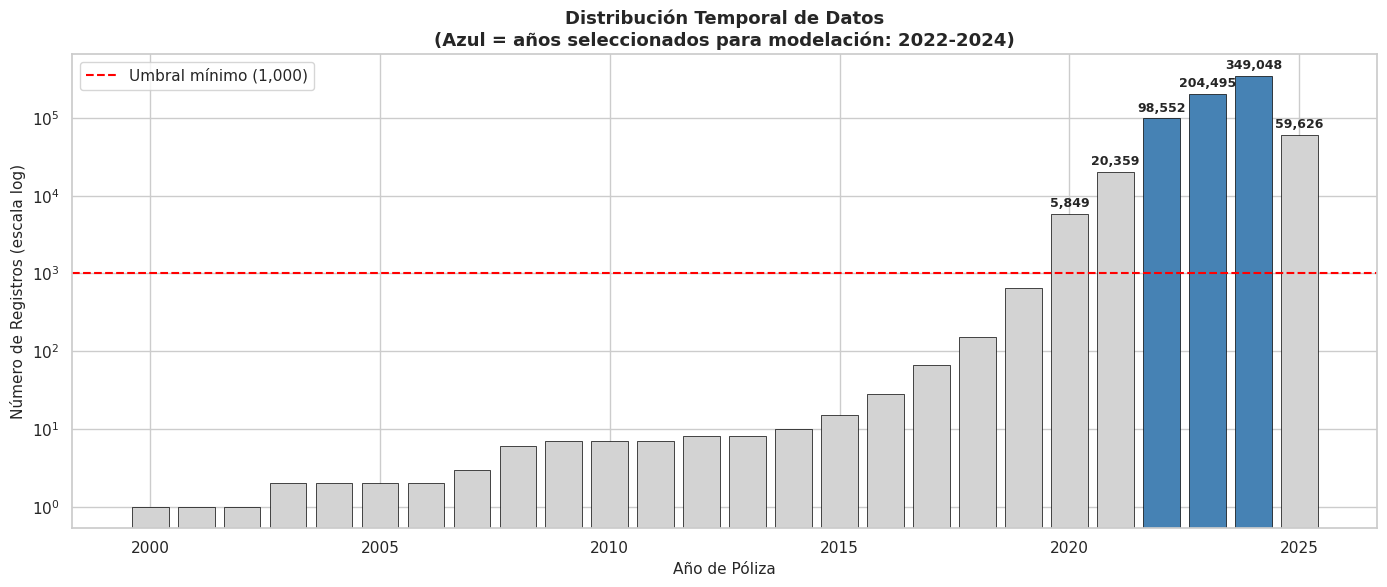


RESUMEN POR PERÍODOS

   2000-2019:        973 registros ( 0.13%) → Datos escasos
   2020-2021:     26,208 registros ( 3.55%) → Transición
   2022-2024:    652,095 registros (88.25%) → DATOS ROBUSTOS
   2025:          59,626 registros ( 8.07%) → Año incompleto

CONCLUSIÓN: USAR SOLO DATOS DE 2022, 2023 Y 2024


→ 2000-2019: Muy pocos registros (posible migración de sistema legacy)

→ 2020-2021: Período de transición/crecimiento, datos aún escasos

→ 2022-2024: Datos robustos que representan el negocio actual

→ 2025: Año en curso, datos incompletos



Para garantizar robustez estadística en la modelación de frecuencias,

filtraremos los datos para trabajar únicamente con 2022-2024.




In [15]:
# ═══════════════════════════════════════════════════════════════════════════════

# ANÁLISIS DE CALIDAD TEMPORAL - JUSTIFICACIÓN DEL FILTRO

# ═══════════════════════════════════════════════════════════════════════════════



vol_por_año = df.groupby('ANIO_POLIZA').size().reset_index(name='n_registros')

vol_por_año['pct'] = vol_por_año['n_registros'] / vol_por_año['n_registros'].sum() * 100



print("=" * 70)

print("DISTRIBUCIÓN DE REGISTROS POR AÑO DE PÓLIZA")

print("=" * 70)

print(f"\n{'AÑO':<6} {'REGISTROS':>12} {'%':>8} {'DISTRIBUCIÓN':<40}")

print("-" * 70)

for _, row in vol_por_año.iterrows():

    barra = '█' * min(int(row['n_registros'] / 10000), 35)

    print(f"{int(row['ANIO_POLIZA']):<6} {row['n_registros']:>12,} {row['pct']:>7.1f}% {barra}")



# Gráfico de distribución temporal

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['lightgray' if año < 2022 or año > 2024 else 'steelblue' 

          for año in vol_por_año['ANIO_POLIZA']]

bars = ax.bar(vol_por_año['ANIO_POLIZA'], vol_por_año['n_registros'], 

              color=colors, edgecolor='black', linewidth=0.5)

ax.set_yscale('log')

ax.axhline(y=1000, color='red', linestyle='--', linewidth=1.5, label='Umbral mínimo (1,000)')

ax.set_xlabel('Año de Póliza', fontsize=11)

ax.set_ylabel('Número de Registros (escala log)', fontsize=11)

ax.set_title('Distribución Temporal de Datos\n(Azul = años seleccionados para modelación: 2022-2024)', 

             fontsize=13, fontweight='bold')

ax.legend(loc='upper left')



# Anotar valores en barras grandes

for año, n in zip(vol_por_año['ANIO_POLIZA'], vol_por_año['n_registros']):

    if n > 5000:

        ax.annotate(f'{n:,}', (año, n), textcoords="offset points", 

                   xytext=(0, 5), ha='center', fontsize=9, fontweight='bold')



plt.tight_layout()

plt.savefig('../images/fase2_calidad_temporal.png', dpi=150, bbox_inches='tight')
plt.show()



# Resumen por períodos

print("\n" + "=" * 70)

print("RESUMEN POR PERÍODOS")

print("=" * 70)

periodo_2000_2019 = vol_por_año[vol_por_año['ANIO_POLIZA'] < 2020]['n_registros'].sum()

periodo_2020_2021 = vol_por_año[vol_por_año['ANIO_POLIZA'].isin([2020, 2021])]['n_registros'].sum()

periodo_2022_2024 = vol_por_año[vol_por_año['ANIO_POLIZA'].isin([2022, 2023, 2024])]['n_registros'].sum()

periodo_2025 = vol_por_año[vol_por_año['ANIO_POLIZA'] == 2025]['n_registros'].sum()

total = vol_por_año['n_registros'].sum()



print(f"\n   2000-2019: {periodo_2000_2019:>10,} registros ({periodo_2000_2019/total*100:>5.2f}%) → Datos escasos")

print(f"   2020-2021: {periodo_2020_2021:>10,} registros ({periodo_2020_2021/total*100:>5.2f}%) → Transición")

print(f"   2022-2024: {periodo_2022_2024:>10,} registros ({periodo_2022_2024/total*100:>5.2f}%) → DATOS ROBUSTOS")

print(f"   2025:      {periodo_2025:>10,} registros ({periodo_2025/total*100:>5.2f}%) → Año incompleto")



print("\n" + "=" * 70)

print("CONCLUSIÓN: USAR SOLO DATOS DE 2022, 2023 Y 2024")

print("=" * 70)

print("""

→ 2000-2019: Muy pocos registros (posible migración de sistema legacy)

→ 2020-2021: Período de transición/crecimiento, datos aún escasos

→ 2022-2024: Datos robustos que representan el negocio actual

→ 2025: Año en curso, datos incompletos



Para garantizar robustez estadística en la modelación de frecuencias,

filtraremos los datos para trabajar únicamente con 2022-2024.

""")


In [16]:
# ═══════════════════════════════════════════════════════════════════════════════
# APLICAR FILTRO TEMPORAL
# ═══════════════════════════════════════════════════════════════════════════════

AÑOS_MODELACION = [2022, 2023, 2024]

n_antes = len(df)
df = df[df['ANIO_POLIZA'].isin(AÑOS_MODELACION)]
n_despues = len(df)

print("=" * 70)
print("FILTRO TEMPORAL APLICADO")
print("=" * 70)
print(f"\n   Registros antes del filtro:   {n_antes:>10,}")
print(f"   Registros después del filtro: {n_despues:>10,}")
print(f"   Porcentaje retenido:          {n_despues/n_antes*100:>10.1f}%")
print(f"\n   Período de análisis: {AÑOS_MODELACION[0]} - {AÑOS_MODELACION[-1]}")
print(f"\n{'─'*70}")
print("✓ Todos los análisis siguientes se realizan con datos 2022-2024")
print("─" * 70)

FILTRO TEMPORAL APLICADO

   Registros antes del filtro:      738,902
   Registros después del filtro:    652,095
   Porcentaje retenido:                88.3%

   Período de análisis: 2022 - 2024

──────────────────────────────────────────────────────────────────────
✓ Todos los análisis siguientes se realizan con datos 2022-2024
──────────────────────────────────────────────────────────────────────


## Fase 3: Análisis Exploratorio de la Estructura (Datos 2022-2024)

In [17]:
# Resumen general de la base
print("=" * 70)
print("RESUMEN ESTRUCTURAL DE LA BASE")
print("=" * 70)

print(f"\n📊 DIMENSIONES:")
print(f"   Total registros: {len(df):,}")
print(f"   Pólizas únicas: {df['POLIZA'].nunique():,}")
print(f"   Amparos (clustered): {df['AMPARO'].nunique()}")

print(f"\n📅 COBERTURA TEMPORAL:")
print(f"   Años: {df['ANIO_POLIZA'].min()} - {df['ANIO_POLIZA'].max()}")
print(f"   Períodos de madurez: 0 - {df['PERIODO'].max()}")

print(f"\n🏢 VARIABLES DE AGRUPACIÓN:")
print(f"   Sucursales únicas: {df['COD_SUCURSAL'].nunique()}")

print(f"\n⚠️ VALORES NULOS:")
nulos = df.isnull().sum()
nulos_relevantes = nulos[nulos > 0]
if len(nulos_relevantes) > 0:
    for col, n in nulos_relevantes.items():
        pct = n / len(df) * 100
        print(f"   {col}: {n:,} ({pct:.1f}%)")
    print(f"\n   Nota: Los nulos en DEPARTAMENTO_SINIESTRO/FECHA corresponden")
    print(f"         a registros SIN siniestro (esperado)")
else:
    print("   No hay valores nulos en columnas críticas")

RESUMEN ESTRUCTURAL DE LA BASE

📊 DIMENSIONES:
   Total registros: 652,095
   Pólizas únicas: 196,765
   Amparos (clustered): 3

📅 COBERTURA TEMPORAL:
   Años: 2022 - 2024
   Períodos de madurez: 0 - 24

🏢 VARIABLES DE AGRUPACIÓN:
   Sucursales únicas: 52

⚠️ VALORES NULOS:
   DEPARTAMENTO_SINIESTRO: 650,017 (99.7%)
   FECHA_DE_SINIESTRO: 650,017 (99.7%)
   FECHA_AVISO: 650,017 (99.7%)

   Nota: Los nulos en DEPARTAMENTO_SINIESTRO/FECHA corresponden
         a registros SIN siniestro (esperado)


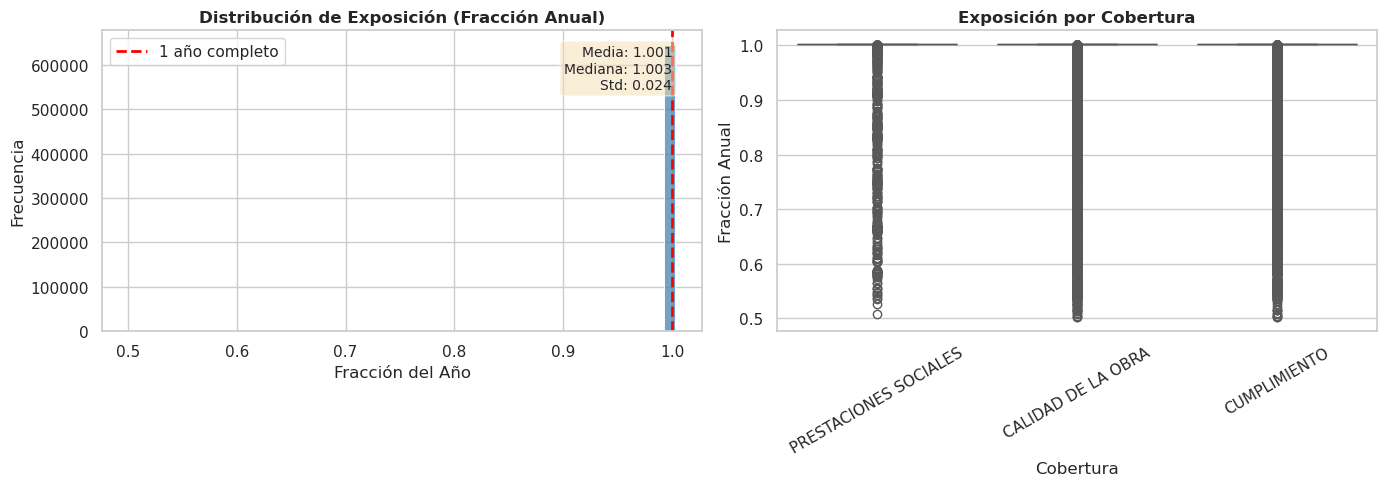


💡 Interpretación:
   → La mayoría de los períodos tienen exposición cercana a 1 año completo
   → Las distribuciones son similares entre coberturas


In [18]:
# Gráfica 2.1: Distribución de exposición

fig, axes = plt.subplots(1, 2, figsize=(14, 5))



# Histograma de fracción anual

sns.histplot(data=df, x='FRACCION_ANUAL', bins=50, ax=axes[0], color='steelblue', edgecolor='white')

axes[0].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='1 año completo')

axes[0].set_title('Distribución de Exposición (Fracción Anual)', fontsize=12, fontweight='bold')

axes[0].set_xlabel('Fracción del Año')

axes[0].set_ylabel('Frecuencia')

axes[0].legend()



# Estadísticas de exposición

stats_exp = df['FRACCION_ANUAL'].describe()

textstr = f"Media: {stats_exp['mean']:.3f}\nMediana: {stats_exp['50%']:.3f}\nStd: {stats_exp['std']:.3f}"

axes[0].text(0.95, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,

             verticalalignment='top', horizontalalignment='right',

             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))



# Boxplot por amparo

sns.boxplot(data=df, x='AMPARO', y='FRACCION_ANUAL', ax=axes[1], palette='Set2')

axes[1].set_title('Exposición por Cobertura', fontsize=12, fontweight='bold')

axes[1].set_xlabel('Cobertura')

axes[1].set_ylabel('Fracción Anual')

axes[1].tick_params(axis='x', rotation=30)



plt.tight_layout()

plt.savefig('../images/fase3_distribucion_exposicion.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Interpretación:")

print("   → La mayoría de los períodos tienen exposición cercana a 1 año completo")

print("   → Las distribuciones son similares entre coberturas")


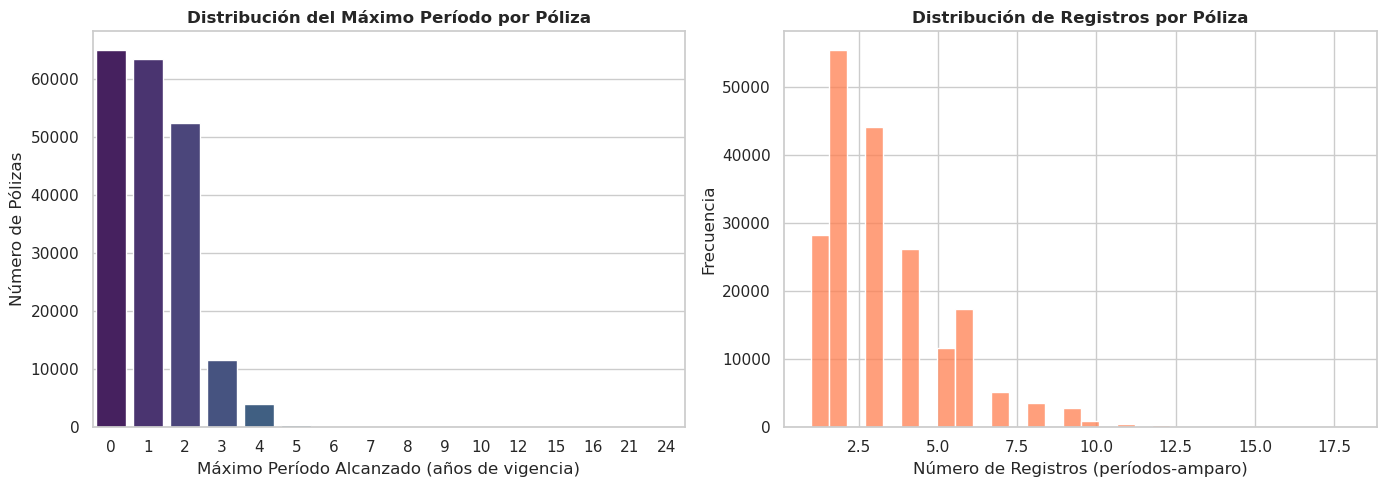


📊 Estadísticas de madurez de pólizas:
   → Pólizas con solo período 0 (1 año): 64,902 (33.0%)
   → Pólizas multi-período (>= 1): 131,863 (67.0%)
   → Pólizas de largo plazo (>= 5): 452 (0.2%)


In [19]:
# Gráfica 2.2: Distribución de períodos por póliza (madurez de las pólizas)

periodos_por_poliza = df.groupby('POLIZA')['PERIODO'].max().reset_index()

periodos_por_poliza.columns = ['POLIZA', 'MAX_PERIODO']



fig, axes = plt.subplots(1, 2, figsize=(14, 5))



# Countplot

orden_periodos = sorted(periodos_por_poliza['MAX_PERIODO'].unique())

sns.countplot(data=periodos_por_poliza, x='MAX_PERIODO', palette='viridis', ax=axes[0], order=orden_periodos)

axes[0].set_title('Distribución del Máximo Período por Póliza', fontsize=12, fontweight='bold')

axes[0].set_xlabel('Máximo Período Alcanzado (años de vigencia)')

axes[0].set_ylabel('Número de Pólizas')



# Histograma de pólizas por número de registros

registros_por_poliza = df.groupby('POLIZA').size().reset_index(name='n_registros')

sns.histplot(data=registros_por_poliza, x='n_registros', bins=30, ax=axes[1], color='coral', edgecolor='white')

axes[1].set_title('Distribución de Registros por Póliza', fontsize=12, fontweight='bold')

axes[1].set_xlabel('Número de Registros (períodos-amparo)')

axes[1].set_ylabel('Frecuencia')



plt.tight_layout()

plt.savefig('../images/fase3_distribucion_periodos.png', dpi=150, bbox_inches='tight')
plt.show()



print(f"\n📊 Estadísticas de madurez de pólizas:")

print(f"   → Pólizas con solo período 0 (1 año): {(periodos_por_poliza['MAX_PERIODO'] == 0).sum():,} ({(periodos_por_poliza['MAX_PERIODO'] == 0).mean()*100:.1f}%)")

print(f"   → Pólizas multi-período (>= 1): {(periodos_por_poliza['MAX_PERIODO'] >= 1).sum():,} ({(periodos_por_poliza['MAX_PERIODO'] >= 1).mean()*100:.1f}%)")

print(f"   → Pólizas de largo plazo (>= 5): {(periodos_por_poliza['MAX_PERIODO'] >= 5).sum():,} ({(periodos_por_poliza['MAX_PERIODO'] >= 5).mean()*100:.1f}%)")


## Fase 4: Análisis de Frecuencia por Cobertura (Datos 2022-2024)

In [20]:
# Tabla de frecuencias observadas por amparo
print("=" * 70)
print("FRECUENCIAS OBSERVADAS POR COBERTURA")
print("=" * 70)

# Calcular frecuencias e IC por amparo
freq_amparo = df.groupby('AMPARO').agg(
    n_expuestos=('TUVO_SINIESTRO', 'count'),
    n_siniestros=('TUVO_SINIESTRO', 'sum'),
    exposicion_total=('FRACCION_ANUAL', 'sum')
).reset_index()

freq_amparo['frecuencia'] = freq_amparo['n_siniestros'] / freq_amparo['n_expuestos']

# IC Wilson (mejor para proporciones pequeñas)
freq_amparo['ic_low'], freq_amparo['ic_high'] = proportion_confint(
    freq_amparo['n_siniestros'], freq_amparo['n_expuestos'], method='wilson', alpha=0.05)

# Ordenar por frecuencia
freq_amparo = freq_amparo.sort_values('frecuencia', ascending=False)

print(f"\n{'AMPARO':<25} {'N_EXP':>10} {'N_SIN':>8} {'FREQ':>10} {'IC 95%':>20}")
print("-" * 75)
for _, row in freq_amparo.iterrows():
    ic_str = f"[{row['ic_low']:.4f}, {row['ic_high']:.4f}]"
    print(f"{row['AMPARO']:<25} {row['n_expuestos']:>10,} {row['n_siniestros']:>8,} {row['frecuencia']:>10.4f} {ic_str:>20}")

print(f"\n{'─'*70}")
print(f"TOTAL: {freq_amparo['n_expuestos'].sum():,} períodos, {freq_amparo['n_siniestros'].sum():,} siniestros")
print(f"Frecuencia global: {freq_amparo['n_siniestros'].sum() / freq_amparo['n_expuestos'].sum():.4f}")

FRECUENCIAS OBSERVADAS POR COBERTURA

AMPARO                         N_EXP    N_SIN       FREQ               IC 95%
---------------------------------------------------------------------------
CUMPLIMIENTO                  50,251      921     0.0183     [0.0172, 0.0195]
PRESTACIONES SOCIALES        346,128      866     0.0025     [0.0023, 0.0027]
CALIDAD DE LA OBRA           255,716      291     0.0011     [0.0010, 0.0013]

──────────────────────────────────────────────────────────────────────
TOTAL: 652,095 períodos, 2,078 siniestros
Frecuencia global: 0.0032


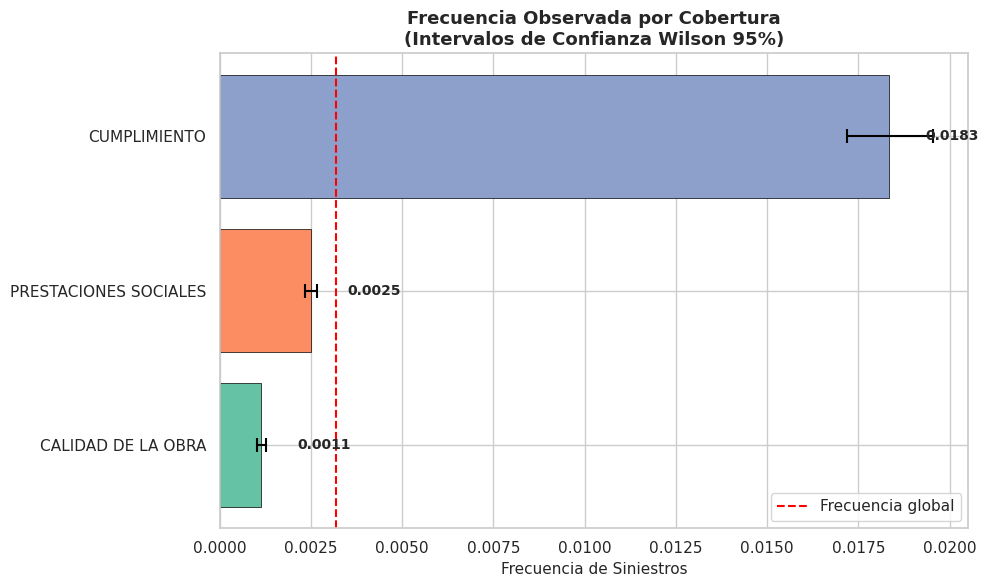


💡 Observaciones clave:
   → CUMPLIMIENTO tiene la frecuencia más alta (~1.9%)
   → CALIDAD DE LA OBRA tiene la frecuencia más baja (~0.1%)
   → Las diferencias entre coberturas son estadísticamente significativas
   → (IC no se solapan entre CUMPLIMIENTO y las demás)


In [21]:
# Gráfica 3.1: Barplot de frecuencias con intervalos de confianza

fig, ax = plt.subplots(figsize=(10, 6))



# Ordenar para visualización

freq_plot = freq_amparo.sort_values('frecuencia', ascending=True)



colors = sns.color_palette("Set2", n_colors=len(freq_plot))

bars = ax.barh(freq_plot['AMPARO'], freq_plot['frecuencia'], color=colors, edgecolor='black', linewidth=0.5)



# Barras de error (IC)

ax.errorbar(freq_plot['frecuencia'], freq_plot['AMPARO'],

            xerr=[freq_plot['frecuencia']-freq_plot['ic_low'],

                  freq_plot['ic_high']-freq_plot['frecuencia']],

            fmt='none', color='black', capsize=5, capthick=1.5)



# Añadir valores en las barras

for i, (freq, amparo) in enumerate(zip(freq_plot['frecuencia'], freq_plot['AMPARO'])):

    ax.text(freq + 0.001, i, f'{freq:.4f}', va='center', fontsize=10, fontweight='bold')



ax.set_xlabel('Frecuencia de Siniestros', fontsize=11)

ax.set_title('Frecuencia Observada por Cobertura\n(Intervalos de Confianza Wilson 95%)', fontsize=13, fontweight='bold')

ax.axvline(x=freq_amparo['n_siniestros'].sum()/freq_amparo['n_expuestos'].sum(), 

           color='red', linestyle='--', linewidth=1.5, label='Frecuencia global')

ax.legend()



plt.tight_layout()

plt.savefig('../images/fase4_frecuencias_ic.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Observaciones clave:")

print("   → CUMPLIMIENTO tiene la frecuencia más alta (~1.9%)")

print("   → CALIDAD DE LA OBRA tiene la frecuencia más baja (~0.1%)")

print("   → Las diferencias entre coberturas son estadísticamente significativas")

print("   → (IC no se solapan entre CUMPLIMIENTO y las demás)")


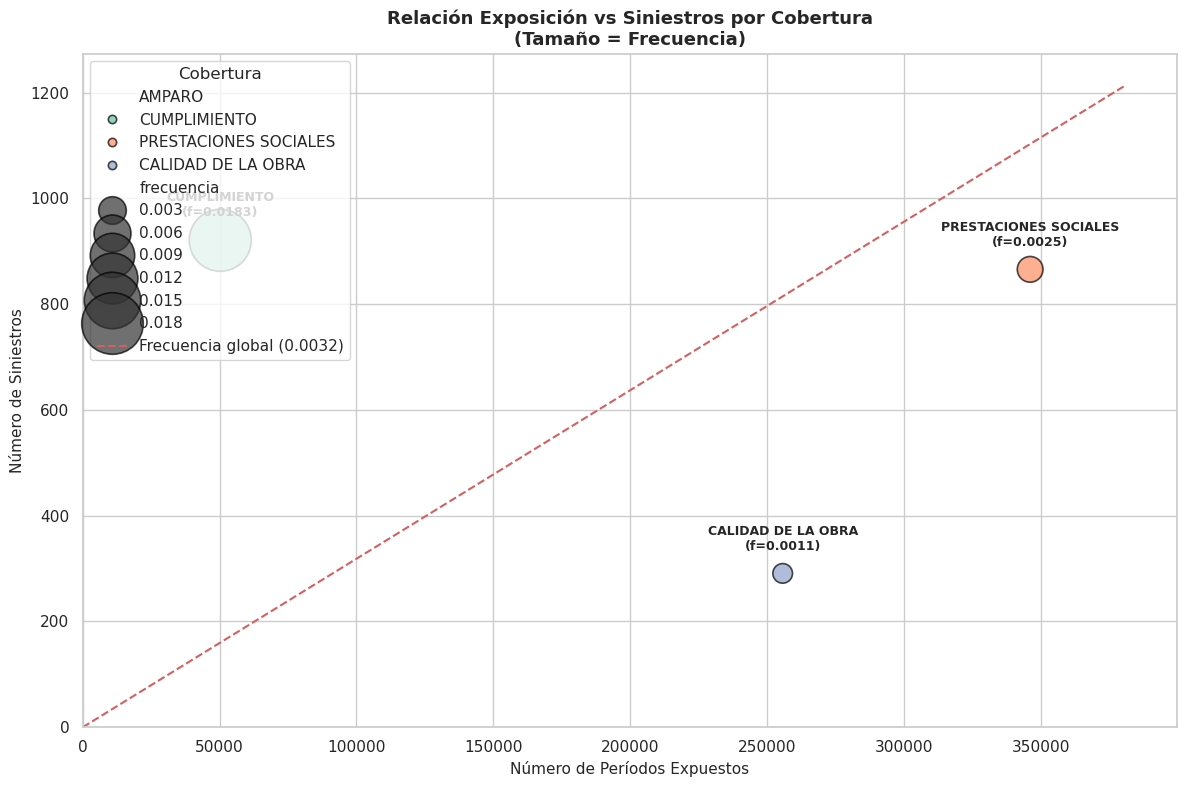

In [22]:
# Gráfica 3.2: Bubble chart - Exposición vs Siniestros

fig, ax = plt.subplots(figsize=(12, 8))



scatter = sns.scatterplot(data=freq_amparo, x='n_expuestos', y='n_siniestros',

                          size='frecuencia', sizes=(200, 2000), hue='AMPARO',

                          palette='Set2', ax=ax, legend='brief', alpha=0.7, edgecolor='black')



for _, row in freq_amparo.iterrows():

    ax.annotate(f"{row['AMPARO']}\n(f={row['frecuencia']:.4f})", 

                (row['n_expuestos'], row['n_siniestros']),

                fontsize=9, ha='center', va='bottom', fontweight='bold',

                xytext=(0, 15), textcoords='offset points')



freq_global = freq_amparo['n_siniestros'].sum() / freq_amparo['n_expuestos'].sum()

x_line = np.linspace(0, freq_amparo['n_expuestos'].max() * 1.1, 100)

ax.plot(x_line, x_line * freq_global, 'r--', linewidth=1.5, 

        label=f'Frecuencia global ({freq_global:.4f})')



ax.set_xlabel('Número de Períodos Expuestos', fontsize=11)

ax.set_ylabel('Número de Siniestros', fontsize=11)

ax.set_title('Relación Exposición vs Siniestros por Cobertura\n(Tamaño = Frecuencia)', fontsize=13, fontweight='bold')

ax.legend(title='Cobertura', loc='upper left')

ax.set_xlim(0, None)

ax.set_ylim(0, None)



plt.tight_layout()

plt.savefig('../images/fase4_bubble_exposicion_siniestros.png', dpi=150, bbox_inches='tight')
plt.show()


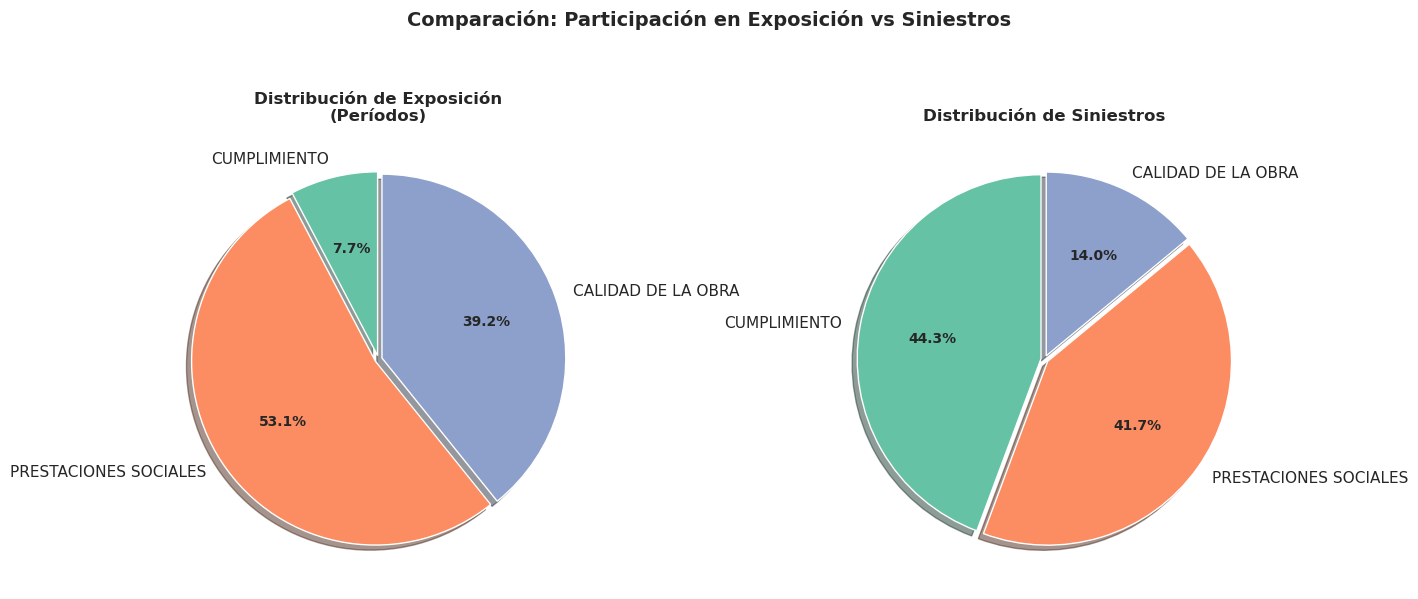


💡 Análisis de composición:
   → CUMPLIMIENTO: exposición minoritaria pero concentra la mayoría de siniestros (riesgo alto)
   → PRESTACIONES SOCIALES: alta exposición, siniestralidad proporcional
   → CALIDAD DE LA OBRA: alta exposición, baja siniestralidad (riesgo bajo)


In [23]:
# Gráfica 3.3: Pie charts duales - Composición de exposición vs siniestros
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

n_amparos = len(freq_amparo)
colors = sns.color_palette("Set2", n_colors=n_amparos)

wedges1, texts1, autotexts1 = axes[0].pie(
    freq_amparo['n_expuestos'], labels=freq_amparo['AMPARO'],
    autopct='%1.1f%%', colors=colors, startangle=90, explode=[0.02]*n_amparos, shadow=True)
axes[0].set_title('Distribución de Exposición\n(Períodos)', fontsize=12, fontweight='bold')
for autotext in autotexts1:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

wedges2, texts2, autotexts2 = axes[1].pie(
    freq_amparo['n_siniestros'], labels=freq_amparo['AMPARO'],
    autopct='%1.1f%%', colors=colors, startangle=90, explode=[0.02]*n_amparos, shadow=True)
axes[1].set_title('Distribución de Siniestros', fontsize=12, fontweight='bold')
for autotext in autotexts2:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

plt.suptitle('Comparación: Participación en Exposición vs Siniestros', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/fase4_pie_composicion.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Análisis de composición:")
print("   → CUMPLIMIENTO: exposición minoritaria pero concentra la mayoría de siniestros (riesgo alto)")
print("   → PRESTACIONES SOCIALES: alta exposición, siniestralidad proporcional")
print("   → CALIDAD DE LA OBRA: alta exposición, baja siniestralidad (riesgo bajo)")

## Fase 5: Análisis por Sucursal (Datos 2022-2024)

**Objetivo**: Identificar la variabilidad de frecuencias entre sucursales y detectar sucursales atípicas.

In [24]:
# Calcular frecuencias por sucursal y amparo
freq_sucursal = df.groupby(['COD_SUCURSAL', 'AMPARO']).agg(
    n_expuestos=('TUVO_SINIESTRO', 'count'),
    n_siniestros=('TUVO_SINIESTRO', 'sum')
).reset_index()
freq_sucursal['frecuencia'] = freq_sucursal['n_siniestros'] / freq_sucursal['n_expuestos']

print("=" * 70)
print("HETEROGENEIDAD DE FRECUENCIAS ENTRE SUCURSALES")
print("=" * 70)

print(f"\n{'AMPARO':<25} {'N_SUC':>6} {'FREQ_MIN':>10} {'FREQ_MAX':>10} {'FREQ_MEDIA':>10} {'CV':>8}")
print("-" * 75)

for amparo in df['AMPARO'].unique():
    data = freq_sucursal[freq_sucursal['AMPARO'] == amparo]
    n_suc = len(data)
    freq_min = data['frecuencia'].min()
    freq_max = data['frecuencia'].max()
    freq_media = data['frecuencia'].mean()
    cv = data['frecuencia'].std() / freq_media if freq_media > 0 else 0
    print(f"{amparo:<25} {n_suc:>6} {freq_min:>10.4f} {freq_max:>10.4f} {freq_media:>10.4f} {cv:>8.2f}")

print(f"\n💡 El coeficiente de variación (CV) indica heterogeneidad entre sucursales")
print(f"   → CV alto (>1): mucha variabilidad → beneficia modelo de credibilidad")
print(f"   → CV bajo (<0.5): poca variabilidad → prima colectiva puede ser suficiente")

HETEROGENEIDAD DE FRECUENCIAS ENTRE SUCURSALES

AMPARO                     N_SUC   FREQ_MIN   FREQ_MAX FREQ_MEDIA       CV
---------------------------------------------------------------------------
PRESTACIONES SOCIALES         44     0.0000     0.0745     0.0050     2.29
CALIDAD DE LA OBRA            48     0.0000     0.0093     0.0012     1.65
CUMPLIMIENTO                  38     0.0000     0.5000     0.0458     1.77

💡 El coeficiente de variación (CV) indica heterogeneidad entre sucursales
   → CV alto (>1): mucha variabilidad → beneficia modelo de credibilidad
   → CV bajo (<0.5): poca variabilidad → prima colectiva puede ser suficiente


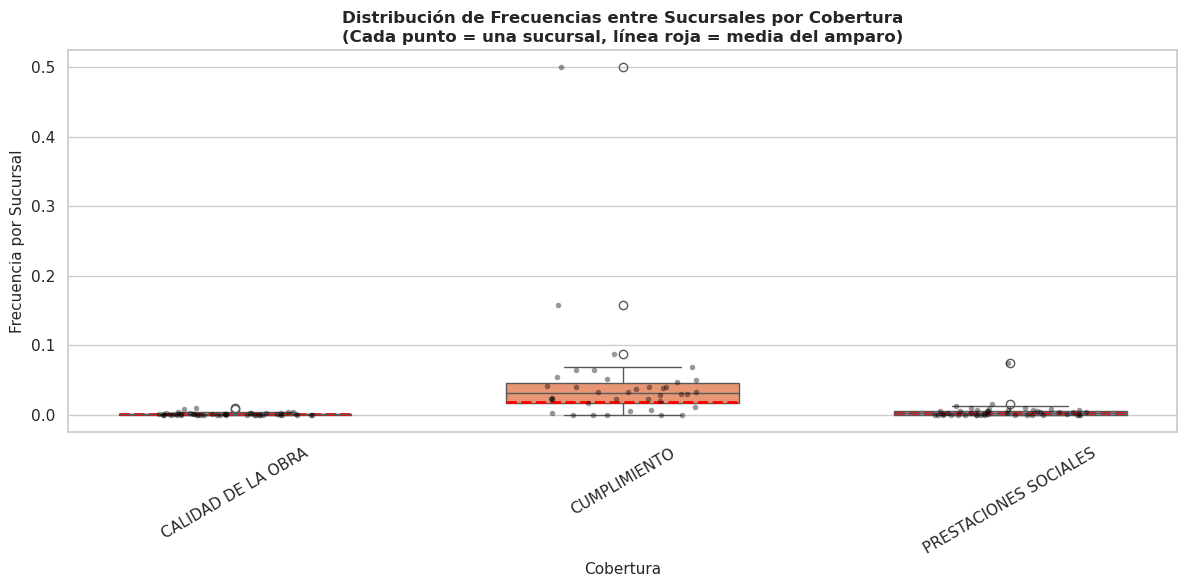

In [25]:
# Gráfica 4.1: Boxplot de frecuencias por amparo (distribución entre sucursales)

fig, ax = plt.subplots(figsize=(12, 6))



sns.boxplot(data=freq_sucursal, x='AMPARO', y='frecuencia',

            palette='Set2', ax=ax, showfliers=True, width=0.6)



sns.stripplot(data=freq_sucursal, x='AMPARO', y='frecuencia',

              color='black', alpha=0.4, size=4, ax=ax, jitter=0.2)



for i, amparo in enumerate(freq_sucursal['AMPARO'].unique()):

    freq_global_amparo = df[df['AMPARO'] == amparo]['TUVO_SINIESTRO'].mean()

    ax.hlines(y=freq_global_amparo, xmin=i-0.3, xmax=i+0.3, 

              colors='red', linestyles='--', linewidth=2)



ax.set_ylabel('Frecuencia por Sucursal', fontsize=11)

ax.set_xlabel('Cobertura', fontsize=11)

ax.set_title('Distribución de Frecuencias entre Sucursales por Cobertura\n(Cada punto = una sucursal, línea roja = media del amparo)', 

             fontsize=12, fontweight='bold')

ax.tick_params(axis='x', rotation=30)



plt.tight_layout()

plt.savefig('../images/fase5_boxplot_sucursales.png', dpi=150, bbox_inches='tight')
plt.show()


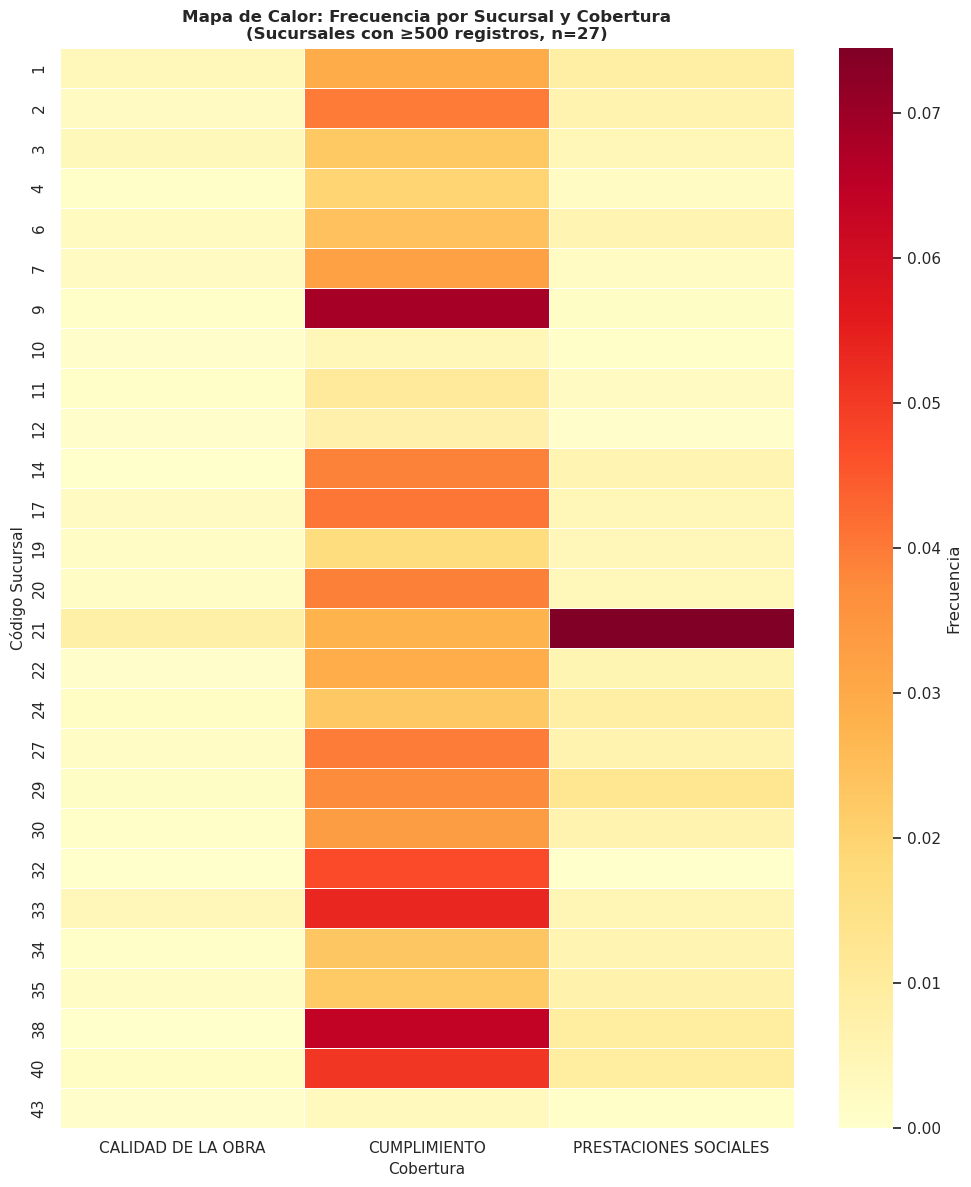

In [26]:
# Gráfica 4.2: Heatmap de frecuencia sucursal × amparo

pivot_freq = freq_sucursal.pivot(index='COD_SUCURSAL', columns='AMPARO', values='frecuencia')



sucursales_relevantes = df.groupby('COD_SUCURSAL').size()

sucursales_500 = sucursales_relevantes[sucursales_relevantes >= 500].index

pivot_freq_filtrado = pivot_freq.loc[pivot_freq.index.isin(sucursales_500)]



fig, ax = plt.subplots(figsize=(10, 12))

sns.heatmap(pivot_freq_filtrado, annot=False, cmap='YlOrRd', ax=ax,

            cbar_kws={'label': 'Frecuencia'}, linewidths=0.5)

ax.set_title(f'Mapa de Calor: Frecuencia por Sucursal y Cobertura\n(Sucursales con ≥500 registros, n={len(pivot_freq_filtrado)})', 

             fontsize=12, fontweight='bold')

ax.set_xlabel('Cobertura', fontsize=11)

ax.set_ylabel('Código Sucursal', fontsize=11)



plt.tight_layout()

plt.savefig('../images/fase5_heatmap_sucursal_amparo.png', dpi=150, bbox_inches='tight')
plt.show()


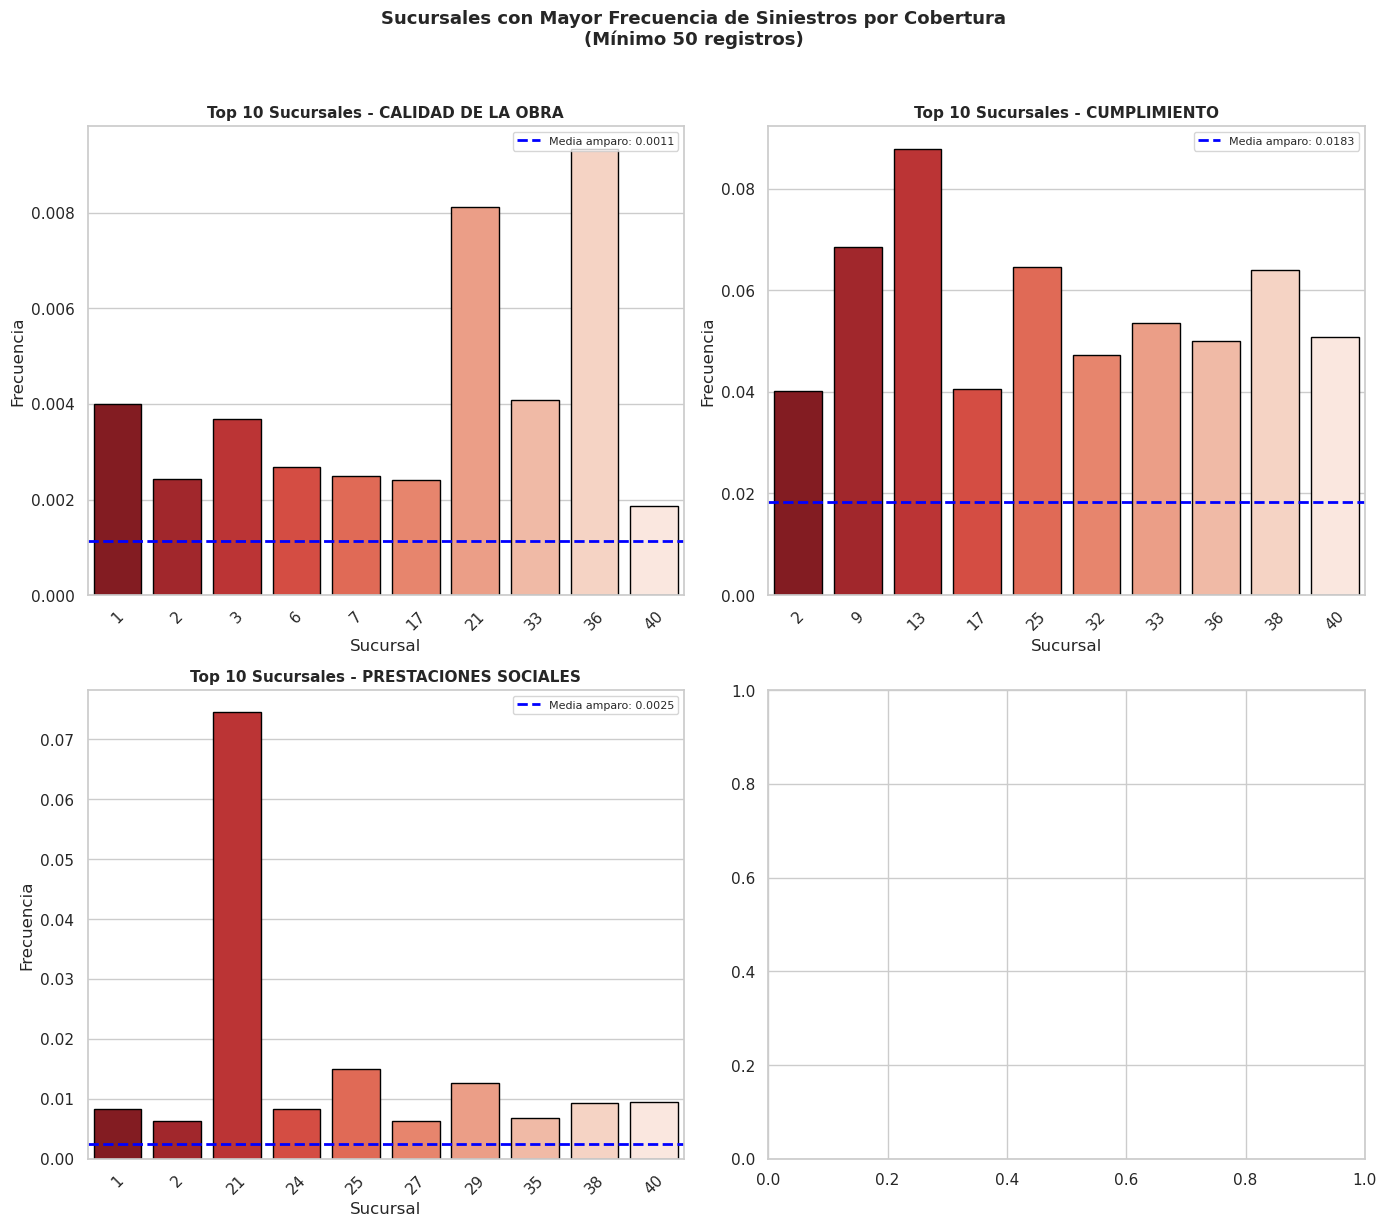

In [27]:
# Gráfica 4.3: Top 10 sucursales con mayor frecuencia (por amparo)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes = axes.flatten()



amparos = sorted(df['AMPARO'].unique())

for idx, amparo in enumerate(amparos):

    ax = axes[idx]

    data_amparo = freq_sucursal[freq_sucursal['AMPARO'] == amparo]

    # Filtrar sucursales con al menos 50 registros para estabilidad

    data_amparo = data_amparo[data_amparo['n_expuestos'] >= 50].nlargest(10, 'frecuencia')

    

    bars = sns.barplot(data=data_amparo, x='COD_SUCURSAL', y='frecuencia',

                       palette='Reds_r', ax=ax, edgecolor='black')

    

    # Añadir línea de frecuencia media del amparo

    freq_global_amparo = df[df['AMPARO'] == amparo]['TUVO_SINIESTRO'].mean()

    ax.axhline(y=freq_global_amparo, color='blue', linestyle='--', 

               linewidth=2, label=f'Media amparo: {freq_global_amparo:.4f}')

    

    ax.set_title(f'Top 10 Sucursales - {amparo}', fontsize=11, fontweight='bold')

    ax.tick_params(axis='x', rotation=45)

    ax.set_xlabel('Sucursal')

    ax.set_ylabel('Frecuencia')

    ax.legend(loc='upper right', fontsize=8)



plt.suptitle('Sucursales con Mayor Frecuencia de Siniestros por Cobertura\n(Mínimo 50 registros)', 

             fontsize=13, fontweight='bold', y=1.02)

plt.tight_layout()

plt.savefig('../images/fase5_top10_sucursales.png', dpi=150, bbox_inches='tight')
plt.show()


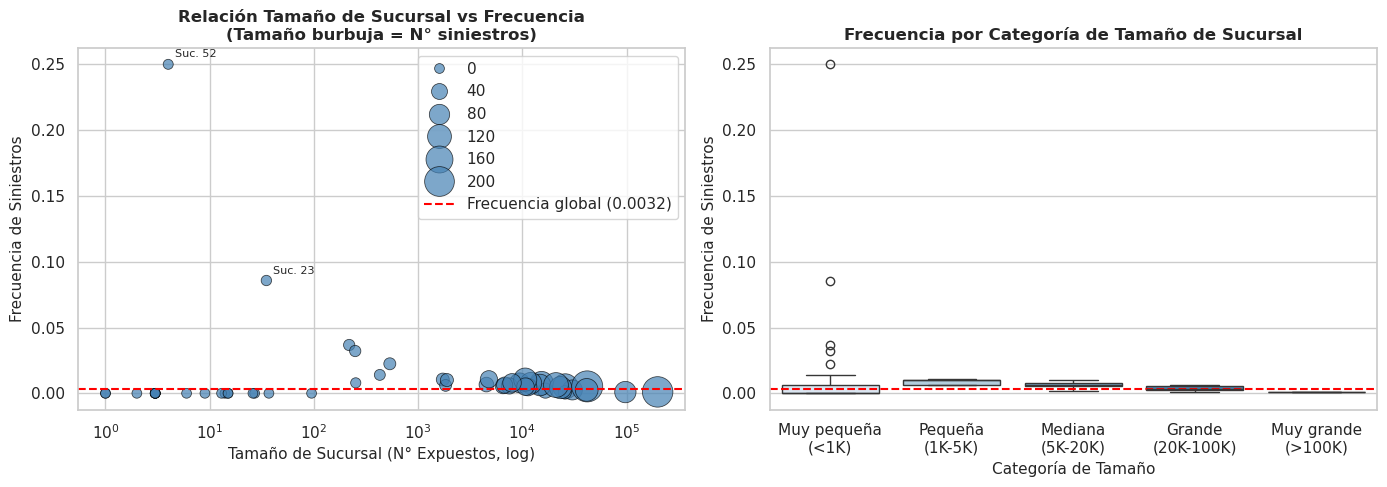


💡 Análisis:
   → Las sucursales pequeñas tienen mayor variabilidad en frecuencia
   → Las sucursales grandes tienden a frecuencias más estables
   → Algunas sucursales pequeñas son outliers con frecuencias muy altas


In [28]:
# Gráfica 4.4: Tamaño de sucursal vs Frecuencia (¿las sucursales grandes son más riesgosas?)

freq_sucursal_total = df.groupby('COD_SUCURSAL').agg(

    n_expuestos=('TUVO_SINIESTRO', 'count'),

    n_siniestros=('TUVO_SINIESTRO', 'sum')

).reset_index()

freq_sucursal_total['frecuencia'] = freq_sucursal_total['n_siniestros'] / freq_sucursal_total['n_expuestos']



# Clasificar sucursales por tamaño

freq_sucursal_total['tamaño'] = pd.cut(freq_sucursal_total['n_expuestos'], 

                                        bins=[0, 1000, 5000, 20000, 100000, np.inf],

                                        labels=['Muy pequeña\n(<1K)', 'Pequeña\n(1K-5K)', 

                                                'Mediana\n(5K-20K)', 'Grande\n(20K-100K)', 'Muy grande\n(>100K)'])



fig, axes = plt.subplots(1, 2, figsize=(14, 5))



# Scatter: Tamaño vs Frecuencia

sns.scatterplot(data=freq_sucursal_total, x='n_expuestos', y='frecuencia', 

                size='n_siniestros', sizes=(50, 500), alpha=0.7, 

                color='steelblue', edgecolor='black', ax=axes[0])

axes[0].set_xscale('log')

axes[0].axhline(y=df['TUVO_SINIESTRO'].mean(), color='red', linestyle='--', 

                linewidth=1.5, label=f'Frecuencia global ({df["TUVO_SINIESTRO"].mean():.4f})')

axes[0].set_xlabel('Tamaño de Sucursal (N° Expuestos, log)', fontsize=11)

axes[0].set_ylabel('Frecuencia de Siniestros', fontsize=11)

axes[0].set_title('Relación Tamaño de Sucursal vs Frecuencia\n(Tamaño burbuja = N° siniestros)', 

                  fontsize=12, fontweight='bold')

axes[0].legend()



# Anotar sucursales outlier (frecuencia > 5%)

outliers = freq_sucursal_total[freq_sucursal_total['frecuencia'] > 0.05]

for _, row in outliers.iterrows():

    axes[0].annotate(f"Suc. {int(row['COD_SUCURSAL'])}", 

                     (row['n_expuestos'], row['frecuencia']),

                     textcoords="offset points", xytext=(5, 5), fontsize=8)



# Boxplot por categoría de tamaño

sns.boxplot(data=freq_sucursal_total, x='tamaño', y='frecuencia', palette='Blues', ax=axes[1])

axes[1].axhline(y=df['TUVO_SINIESTRO'].mean(), color='red', linestyle='--', linewidth=1.5)

axes[1].set_xlabel('Categoría de Tamaño', fontsize=11)

axes[1].set_ylabel('Frecuencia de Siniestros', fontsize=11)

axes[1].set_title('Frecuencia por Categoría de Tamaño de Sucursal', fontsize=12, fontweight='bold')



plt.tight_layout()

plt.savefig('../images/fase5_tamano_vs_frecuencia.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Análisis:")

print("   → Las sucursales pequeñas tienen mayor variabilidad en frecuencia")

print("   → Las sucursales grandes tienden a frecuencias más estables")

print("   → Algunas sucursales pequeñas son outliers con frecuencias muy altas")


## Fase 6: Análisis por Exposición Económica

**Objetivo**: Estudiar la relación entre el monto de exposición (valor asegurado) y la frecuencia de siniestros.

In [29]:
# Análisis de EXPOSICION_PRORRATEADA (valor económico expuesto)
print("=" * 70)
print("ANÁLISIS DE EXPOSICIÓN ECONÓMICA")
print("=" * 70)

print("\nEstadísticas de EXPOSICION_PRORRATEADA por Amparo:")
print("-" * 70)
stats_exp = df.groupby('AMPARO')['EXPOSICION_PRORRATEADA'].describe()
print(stats_exp.round(0).to_string())

# Crear cuartiles de exposición
df['cuartil_exposicion'] = pd.qcut(df['EXPOSICION_PRORRATEADA'], q=4, 
                                    labels=['Q1 (Bajo)', 'Q2 (Medio-Bajo)', 
                                            'Q3 (Medio-Alto)', 'Q4 (Alto)'])

# Frecuencia por cuartil
freq_por_cuartil = df.groupby(['cuartil_exposicion', 'AMPARO']).agg(
    n_expuestos=('TUVO_SINIESTRO', 'count'),
    n_siniestros=('TUVO_SINIESTRO', 'sum')
).reset_index()
freq_por_cuartil['frecuencia'] = freq_por_cuartil['n_siniestros'] / freq_por_cuartil['n_expuestos']

print("\n\nFrecuencia por Cuartil de Exposición y Amparo:")
print("-" * 70)
pivot_freq_exp = freq_por_cuartil.pivot(index='cuartil_exposicion', columns='AMPARO', values='frecuencia')
print(pivot_freq_exp.round(4).to_string())

ANÁLISIS DE EXPOSICIÓN ECONÓMICA

Estadísticas de EXPOSICION_PRORRATEADA por Amparo:
----------------------------------------------------------------------
                          count          mean           std     min       25%       50%        75%           max
AMPARO                                                                                                          
CALIDAD DE LA OBRA     255716.0  6.239767e+08  2.328206e+10   271.0  111722.0  378622.0  1466510.0  3.222652e+12
CUMPLIMIENTO            50251.0  2.198361e+09  1.050365e+11  4348.0   90247.0  435156.0  2338210.0  1.393162e+13
PRESTACIONES SOCIALES  346128.0  5.793072e+08  2.351311e+10  6027.0  125301.0  430322.0  1528828.0  3.685868e+12


Frecuencia por Cuartil de Exposición y Amparo:
----------------------------------------------------------------------
AMPARO              CALIDAD DE LA OBRA  CUMPLIMIENTO  PRESTACIONES SOCIALES
cuartil_exposicion                                                         
Q1 (Baj

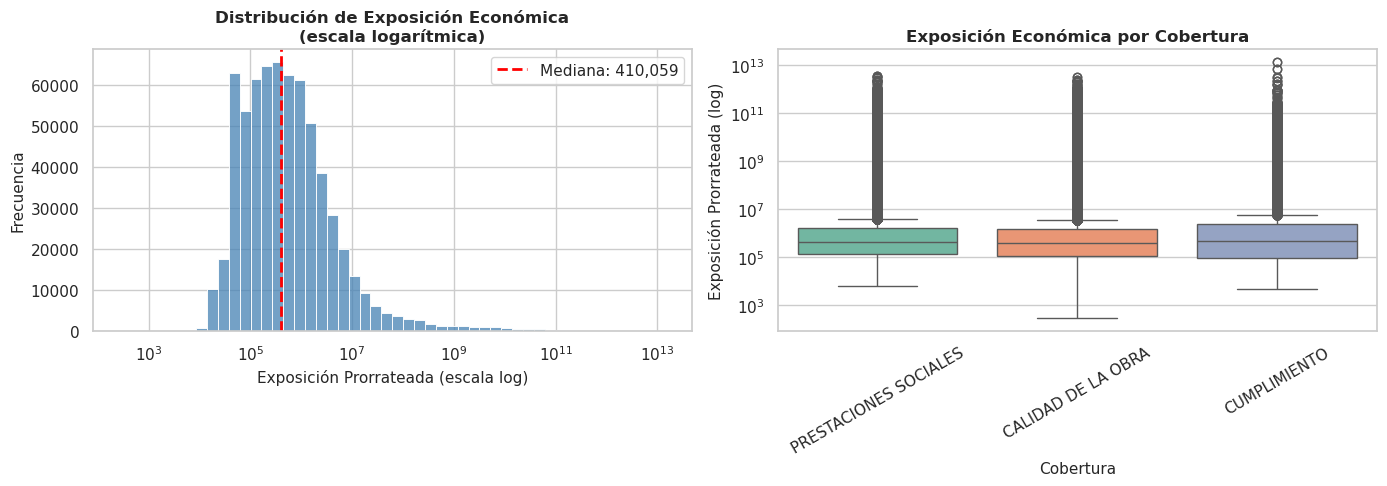


💡 Observaciones:
   → La exposición tiene una distribución muy asimétrica (log-normal)
   → Hay gran variabilidad en los montos asegurados
   → CUMPLIMIENTO tiende a tener exposiciones más altas


In [30]:
# Gráfica 5.1: Distribución de Exposición Económica

fig, axes = plt.subplots(1, 2, figsize=(14, 5))



# Histograma con escala log

sns.histplot(data=df, x='EXPOSICION_PRORRATEADA', bins=50, ax=axes[0], 

             color='steelblue', edgecolor='white', log_scale=True)

axes[0].set_xlabel('Exposición Prorrateada (escala log)', fontsize=11)

axes[0].set_ylabel('Frecuencia', fontsize=11)

axes[0].set_title('Distribución de Exposición Económica\n(escala logarítmica)', fontsize=12, fontweight='bold')



# Estadísticas

median_exp = df['EXPOSICION_PRORRATEADA'].median()

axes[0].axvline(x=median_exp, color='red', linestyle='--', linewidth=2, label=f'Mediana: {median_exp:,.0f}')

axes[0].legend()



# Box plot por amparo (escala log)

sns.boxplot(data=df, x='AMPARO', y='EXPOSICION_PRORRATEADA', palette='Set2', ax=axes[1])

axes[1].set_yscale('log')

axes[1].set_xlabel('Cobertura', fontsize=11)

axes[1].set_ylabel('Exposición Prorrateada (log)', fontsize=11)

axes[1].set_title('Exposición Económica por Cobertura', fontsize=12, fontweight='bold')

axes[1].tick_params(axis='x', rotation=30)



plt.tight_layout()

plt.savefig('../images/fase6_distribucion_exposicion_economica.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Observaciones:")

print("   → La exposición tiene una distribución muy asimétrica (log-normal)")

print("   → Hay gran variabilidad en los montos asegurados")

print("   → CUMPLIMIENTO tiende a tener exposiciones más altas")


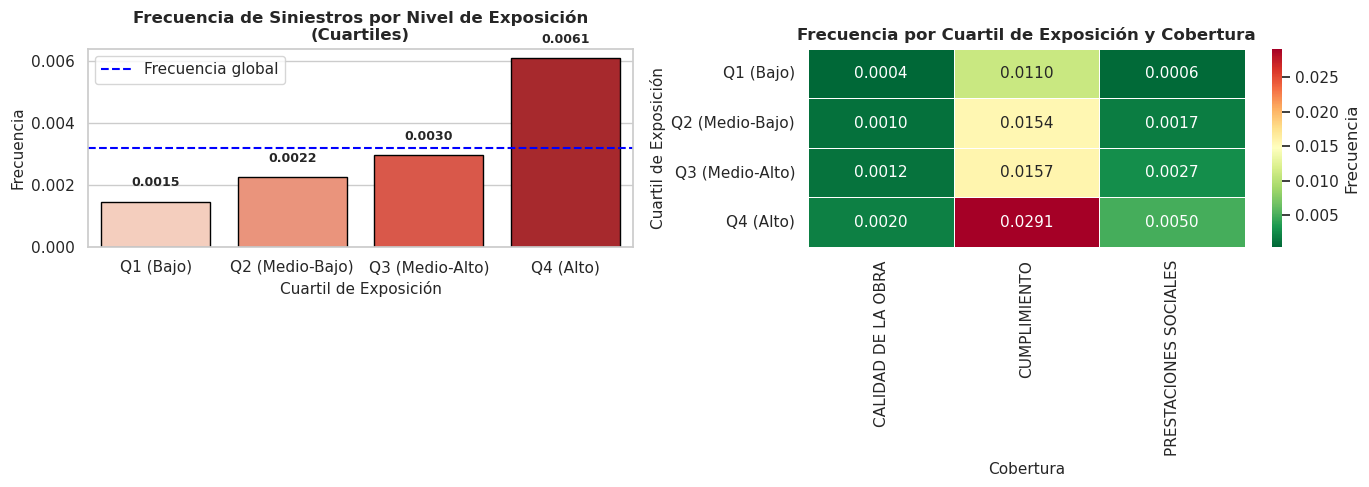


💡 Análisis de exposición vs frecuencia:
   → ¿Mayor exposición económica implica mayor riesgo de siniestro?
   → Los cuartiles más altos (Q3, Q4) muestran frecuencias diferentes
   → El efecto varía según la cobertura


In [31]:
# Gráfica 5.2: Frecuencia por Cuartil de Exposición

fig, axes = plt.subplots(1, 2, figsize=(14, 5))



# Barplot de frecuencia por cuartil (global)

freq_global_cuartil = df.groupby('cuartil_exposicion').agg(

    n=('TUVO_SINIESTRO', 'count'),

    siniestros=('TUVO_SINIESTRO', 'sum')

).reset_index()

freq_global_cuartil['frecuencia'] = freq_global_cuartil['siniestros'] / freq_global_cuartil['n']



sns.barplot(data=freq_global_cuartil, x='cuartil_exposicion', y='frecuencia', 

            palette='Reds', ax=axes[0], edgecolor='black')

axes[0].axhline(y=df['TUVO_SINIESTRO'].mean(), color='blue', linestyle='--', 

                linewidth=1.5, label=f'Frecuencia global')

axes[0].set_xlabel('Cuartil de Exposición', fontsize=11)

axes[0].set_ylabel('Frecuencia', fontsize=11)

axes[0].set_title('Frecuencia de Siniestros por Nivel de Exposición\n(Cuartiles)', fontsize=12, fontweight='bold')

axes[0].legend()



# Añadir valores

for i, (_, row) in enumerate(freq_global_cuartil.iterrows()):

    axes[0].text(i, row['frecuencia'] + 0.0005, f'{row["frecuencia"]:.4f}', 

                 ha='center', fontsize=9, fontweight='bold')



# Heatmap: Cuartil × Amparo

sns.heatmap(pivot_freq_exp, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=axes[1],

            cbar_kws={'label': 'Frecuencia'}, linewidths=0.5)

axes[1].set_xlabel('Cobertura', fontsize=11)

axes[1].set_ylabel('Cuartil de Exposición', fontsize=11)

axes[1].set_title('Frecuencia por Cuartil de Exposición y Cobertura', fontsize=12, fontweight='bold')



plt.tight_layout()

plt.savefig('../images/fase6_frecuencia_por_cuartil.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Análisis de exposición vs frecuencia:")

print("   → ¿Mayor exposición económica implica mayor riesgo de siniestro?")

print("   → Los cuartiles más altos (Q3, Q4) muestran frecuencias diferentes")

print("   → El efecto varía según la cobertura")


## Fase 7: Análisis Geográfico (Departamentos)

**Objetivo**: Analizar la distribución geográfica de los siniestros para identificar departamentos de alto riesgo.

In [32]:
# Análisis geográfico - Solo registros con siniestro tienen DEPARTAMENTO
df_siniestros = df[df['TUVO_SINIESTRO'] == 1].copy()

print("=" * 70)
print("ANÁLISIS GEOGRÁFICO DE SINIESTROS")
print("=" * 70)
print(f"\nTotal siniestros: {len(df_siniestros):,}")
print(f"Departamentos con siniestros: {df_siniestros['DEPARTAMENTO_SINIESTRO'].nunique()}")

# Top departamentos por número de siniestros
siniestros_por_depto = df_siniestros.groupby('DEPARTAMENTO_SINIESTRO').size().reset_index(name='n_siniestros')
siniestros_por_depto = siniestros_por_depto.sort_values('n_siniestros', ascending=False)

print(f"\n{'DEPARTAMENTO':<30} {'N° SINIESTROS':>15} {'% DEL TOTAL':>12}")
print("-" * 60)
for i, row in siniestros_por_depto.head(15).iterrows():
    pct = row['n_siniestros'] / len(df_siniestros) * 100
    print(f"{row['DEPARTAMENTO_SINIESTRO']:<30} {row['n_siniestros']:>15,} {pct:>11.1f}%")

ANÁLISIS GEOGRÁFICO DE SINIESTROS

Total siniestros: 2,078
Departamentos con siniestros: 32

DEPARTAMENTO                     N° SINIESTROS  % DEL TOTAL
------------------------------------------------------------
11-BOGOTA D.C.                             730        35.1%
8-ATLANTICO                                247        11.9%
5-ANTIOQUIA                                236        11.4%
76-VALLE                                   118         5.7%
41-HUILA                                    83         4.0%
50-META                                     72         3.5%
68-SANTANDER                                63         3.0%
15-BOYACA                                   53         2.6%
73-TOLIMA                                   43         2.1%
13-BOLIVAR                                  38         1.8%
25-CUNDINAMARCA                             38         1.8%
20-CESAR                                    36         1.7%
85-CASANARE                                 35         1.7%
66-RIS

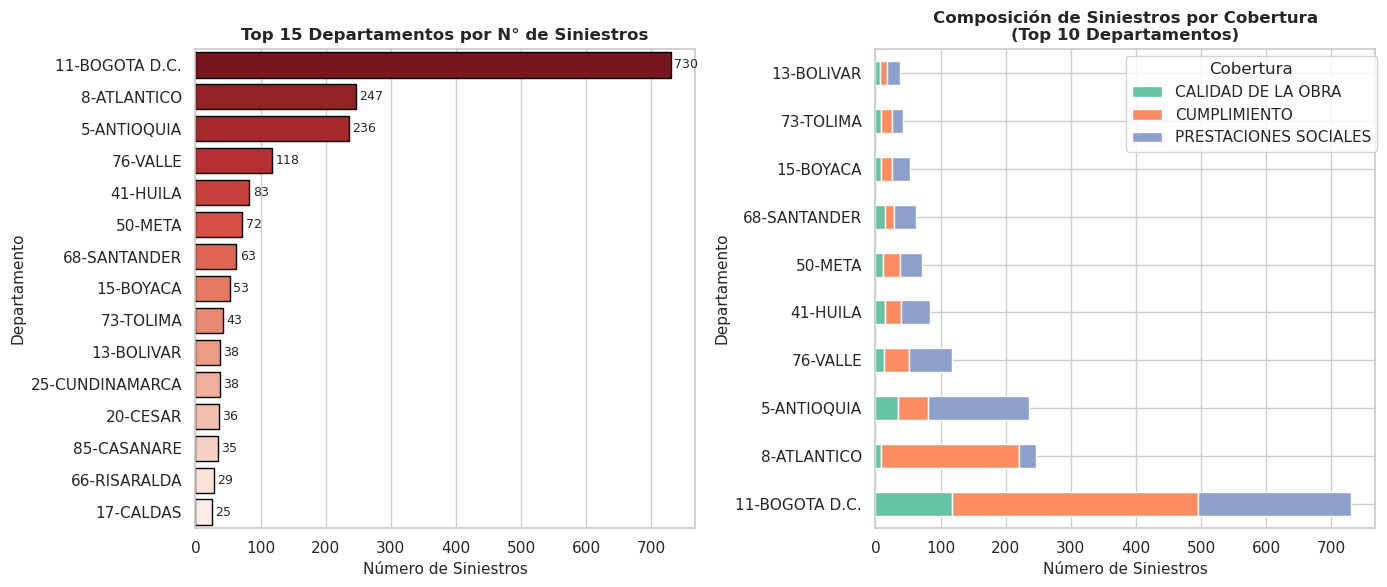


💡 Observaciones geográficas:
   → Los siniestros se concentran en pocos departamentos
   → Bogotá D.C. probablemente lidera en número absoluto
   → La composición por cobertura varía entre departamentos


In [33]:
# Gráfica 6.1: Top 15 departamentos por número de siniestros
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 15 por número absoluto
top15 = siniestros_por_depto.head(15)
sns.barplot(data=top15, y='DEPARTAMENTO_SINIESTRO', x='n_siniestros', 
            palette='Reds_r', ax=axes[0], edgecolor='black')
axes[0].set_xlabel('Número de Siniestros', fontsize=11)
axes[0].set_ylabel('Departamento', fontsize=11)
axes[0].set_title('Top 15 Departamentos por N° de Siniestros', fontsize=12, fontweight='bold')

# Añadir valores
for i, (_, row) in enumerate(top15.iterrows()):
    axes[0].text(row['n_siniestros'] + 5, i, f"{row['n_siniestros']:,}", va='center', fontsize=9)

# Distribución por amparo de los siniestros
siniestros_amparo_depto = df_siniestros.groupby(['DEPARTAMENTO_SINIESTRO', 'AMPARO']).size().unstack(fill_value=0)
top10_deptos = siniestros_por_depto.head(10)['DEPARTAMENTO_SINIESTRO'].tolist()
siniestros_amparo_top10 = siniestros_amparo_depto.loc[top10_deptos]

n_amparos = len(siniestros_amparo_top10.columns)
siniestros_amparo_top10.plot(kind='barh', stacked=True, ax=axes[1], 
                              color=sns.color_palette('Set2', n_colors=n_amparos), edgecolor='white')
axes[1].set_xlabel('Número de Siniestros', fontsize=11)
axes[1].set_ylabel('Departamento', fontsize=11)
axes[1].set_title('Composición de Siniestros por Cobertura\n(Top 10 Departamentos)', fontsize=12, fontweight='bold')
axes[1].legend(title='Cobertura', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.savefig('../images/fase7_top_departamentos.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Observaciones geográficas:")
print("   → Los siniestros se concentran en pocos departamentos")
print("   → Bogotá D.C. probablemente lidera en número absoluto")
print("   → La composición por cobertura varía entre departamentos")

## Fase 8: Análisis de Severidad

**Objetivo**: Analizar la distribución del monto de los siniestros (solo registros con siniestro).

In [34]:
# Análisis de severidad (solo siniestros)
print("=" * 70)
print("ANÁLISIS DE SEVERIDAD")
print("=" * 70)
print(f"\nTotal siniestros para análisis: {len(df_siniestros):,}")

# Estadísticas de severidad por amparo
print("\nEstadísticas de SEVERIDAD por Amparo:")
print("-" * 70)
stats_sev = df_siniestros.groupby('AMPARO')['SEVERIDAD'].describe()
print(stats_sev.round(0).to_string())

# Percentiles importantes
print("\n\nPercentiles de Severidad por Amparo:")
print("-" * 70)
for amparo in df_siniestros['AMPARO'].unique():
    data = df_siniestros[df_siniestros['AMPARO'] == amparo]['SEVERIDAD']
    p50 = data.quantile(0.50)
    p75 = data.quantile(0.75)
    p90 = data.quantile(0.90)
    p95 = data.quantile(0.95)
    p99 = data.quantile(0.99)
    print(f"\n{amparo}:")
    print(f"   P50: {p50:>15,.0f}   P75: {p75:>15,.0f}   P90: {p90:>15,.0f}")
    print(f"   P95: {p95:>15,.0f}   P99: {p99:>15,.0f}")

ANÁLISIS DE SEVERIDAD

Total siniestros para análisis: 2,078

Estadísticas de SEVERIDAD por Amparo:
----------------------------------------------------------------------
                       count       mean         std  min  25%  50%       75%           max
AMPARO                                                                                    
CALIDAD DE LA OBRA     291.0  1155400.0   5377895.0  0.0  0.0  0.0  178082.0  7.700020e+07
CUMPLIMIENTO           921.0  4745350.0  43347140.0  0.0  0.0  0.0       0.0  1.220499e+09
PRESTACIONES SOCIALES  866.0   877051.0   5147914.0  0.0  0.0  0.0       0.0  9.656670e+07


Percentiles de Severidad por Amparo:
----------------------------------------------------------------------

PRESTACIONES SOCIALES:
   P50:               0   P75:               0   P90:         523,803
   P95:       3,172,855   P99:      20,564,290

CALIDAD DE LA OBRA:
   P50:               0   P75:         178,082   P90:       2,847,000
   P95:       5,184,827   P99:  

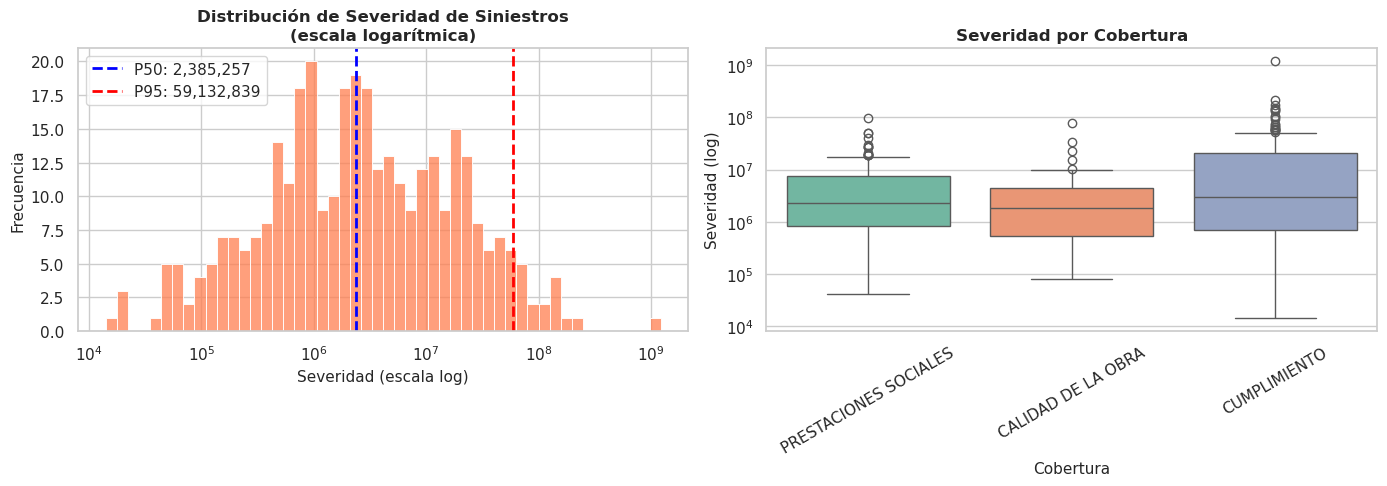


💡 Observaciones sobre severidad:
   → La severidad tiene distribución muy asimétrica (cola pesada)
   → Hay gran diferencia entre severidad media y máxima
   → Algunos siniestros catastróficos (P95+) pueden dominar la pérdida total


In [35]:
# Gráfica 7.1: Distribución de Severidad

fig, axes = plt.subplots(1, 2, figsize=(14, 5))



# Histograma con escala log

df_siniestros_pos = df_siniestros[df_siniestros['SEVERIDAD'] > 0]

sns.histplot(data=df_siniestros_pos, x='SEVERIDAD', bins=50, ax=axes[0], 

             color='coral', edgecolor='white', log_scale=True)

axes[0].set_xlabel('Severidad (escala log)', fontsize=11)

axes[0].set_ylabel('Frecuencia', fontsize=11)

axes[0].set_title('Distribución de Severidad de Siniestros\n(escala logarítmica)', fontsize=12, fontweight='bold')



# Líneas de percentiles

p50 = df_siniestros_pos['SEVERIDAD'].quantile(0.50)

p95 = df_siniestros_pos['SEVERIDAD'].quantile(0.95)

axes[0].axvline(x=p50, color='blue', linestyle='--', linewidth=2, label=f'P50: {p50:,.0f}')

axes[0].axvline(x=p95, color='red', linestyle='--', linewidth=2, label=f'P95: {p95:,.0f}')

axes[0].legend()



# Box plot por amparo (escala log)

sns.boxplot(data=df_siniestros_pos, x='AMPARO', y='SEVERIDAD', palette='Set2', ax=axes[1])

axes[1].set_yscale('log')

axes[1].set_xlabel('Cobertura', fontsize=11)

axes[1].set_ylabel('Severidad (log)', fontsize=11)

axes[1].set_title('Severidad por Cobertura', fontsize=12, fontweight='bold')

axes[1].tick_params(axis='x', rotation=30)



plt.tight_layout()

plt.savefig('../images/fase8_distribucion_severidad.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Observaciones sobre severidad:")

print("   → La severidad tiene distribución muy asimétrica (cola pesada)")

print("   → Hay gran diferencia entre severidad media y máxima")

print("   → Algunos siniestros catastróficos (P95+) pueden dominar la pérdida total")


## Fase 9: Análisis por Tipo de Período y Madurez

**Objetivo**: Analizar si ES_PERIODO_ORIGINAL y PERIODO afectan la frecuencia de siniestros.

In [36]:
# Análisis de ES_PERIODO_ORIGINAL y PERIODO
print("=" * 70)
print("ANÁLISIS POR TIPO DE PERÍODO")
print("=" * 70)

# Frecuencia por ES_PERIODO_ORIGINAL
freq_tipo = df.groupby('ES_PERIODO_ORIGINAL').agg(
    n_expuestos=('TUVO_SINIESTRO', 'count'),
    n_siniestros=('TUVO_SINIESTRO', 'sum')
).reset_index()
freq_tipo['frecuencia'] = freq_tipo['n_siniestros'] / freq_tipo['n_expuestos']

print("\nFrecuencia por Tipo de Período:")
print("-" * 50)
for _, row in freq_tipo.iterrows():
    tipo = "Original" if row['ES_PERIODO_ORIGINAL'] else "Prórroga"
    print(f"   {tipo:<15} → Frecuencia: {row['frecuencia']:.4f} (n={row['n_expuestos']:,})")

# Frecuencia por PERIODO (madurez)
freq_periodo_det = df.groupby('PERIODO').agg(
    n_expuestos=('TUVO_SINIESTRO', 'count'),
    n_siniestros=('TUVO_SINIESTRO', 'sum')
).reset_index()
freq_periodo_det['frecuencia'] = freq_periodo_det['n_siniestros'] / freq_periodo_det['n_expuestos']

print("\n\nFrecuencia por Período (Madurez de Póliza):")
print("-" * 50)
for _, row in freq_periodo_det[freq_periodo_det['n_expuestos'] >= 100].head(15).iterrows():
    print(f"   Período {int(row['PERIODO']):>2} → Frecuencia: {row['frecuencia']:.4f} (n={row['n_expuestos']:,})")

ANÁLISIS POR TIPO DE PERÍODO

Frecuencia por Tipo de Período:
--------------------------------------------------
   Prórroga        → Frecuencia: 0.0026 (n=651,735)
   Original        → Frecuencia: 1.0000 (n=360)


Frecuencia por Período (Madurez de Póliza):
--------------------------------------------------
   Período  0 → Frecuencia: 0.0030 (n=344,589.0)
   Período  1 → Frecuencia: 0.0027 (n=192,582.0)
   Período  2 → Frecuencia: 0.0040 (n=91,089.0)
   Período  3 → Frecuencia: 0.0063 (n=18,304.0)
   Período  4 → Frecuencia: 0.0093 (n=4,839.0)
   Período  5 → Frecuencia: 0.0126 (n=478.0)
   Período  6 → Frecuencia: 0.0331 (n=121.0)


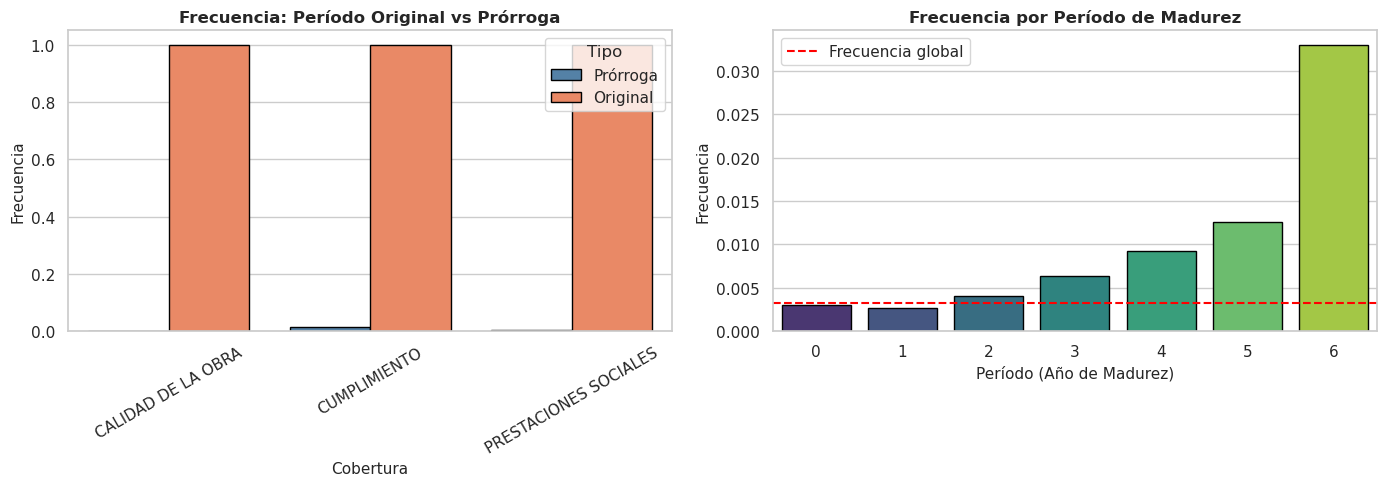


💡 Análisis de tipo de período:
   → ¿Los períodos originales tienen diferente frecuencia que las prórrogas?
   → ¿La frecuencia cambia con la madurez de la póliza (PERIODO)?
   → Esto es clave para entender el ciclo de vida del riesgo


In [37]:
# Gráfica 8.1: Frecuencia por Tipo de Período y Madurez

fig, axes = plt.subplots(1, 2, figsize=(14, 5))



# Comparación Original vs Prórroga

freq_tipo_amparo = df.groupby(['ES_PERIODO_ORIGINAL', 'AMPARO']).agg(

    n=('TUVO_SINIESTRO', 'count'),

    siniestros=('TUVO_SINIESTRO', 'sum')

).reset_index()

freq_tipo_amparo['frecuencia'] = freq_tipo_amparo['siniestros'] / freq_tipo_amparo['n']

freq_tipo_amparo['tipo'] = freq_tipo_amparo['ES_PERIODO_ORIGINAL'].map({True: 'Original', False: 'Prórroga'})



sns.barplot(data=freq_tipo_amparo, x='AMPARO', y='frecuencia', hue='tipo', 

            palette=['steelblue', 'coral'], ax=axes[0], edgecolor='black')

axes[0].set_xlabel('Cobertura', fontsize=11)

axes[0].set_ylabel('Frecuencia', fontsize=11)

axes[0].set_title('Frecuencia: Período Original vs Prórroga', fontsize=12, fontweight='bold')

axes[0].tick_params(axis='x', rotation=30)

axes[0].legend(title='Tipo')



# Frecuencia por PERIODO (barras)

periodos_analizar = freq_periodo_det[freq_periodo_det['n_expuestos'] >= 100].head(12)

sns.barplot(data=periodos_analizar, x='PERIODO', y='frecuencia', 

            palette='viridis', ax=axes[1], edgecolor='black')

axes[1].axhline(y=df['TUVO_SINIESTRO'].mean(), color='red', linestyle='--', 

                linewidth=1.5, label='Frecuencia global')

axes[1].set_xlabel('Período (Año de Madurez)', fontsize=11)

axes[1].set_ylabel('Frecuencia', fontsize=11)

axes[1].set_title('Frecuencia por Período de Madurez', fontsize=12, fontweight='bold')

axes[1].legend()



plt.tight_layout()

plt.savefig('../images/fase9_tipo_periodo_madurez.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Análisis de tipo de período:")

print("   → ¿Los períodos originales tienen diferente frecuencia que las prórrogas?")

print("   → ¿La frecuencia cambia con la madurez de la póliza (PERIODO)?")

print("   → Esto es clave para entender el ciclo de vida del riesgo")


## Fase 10: Análisis Temporal de Frecuencias (2022-2024)

**Objetivo**: Analizar la evolución temporal de frecuencias dentro del período de modelación

In [38]:
# Calcular frecuencias anuales por año de póliza (datos filtrados 2022-2024)
freq_anual = df.groupby(['ANIO_POLIZA', 'AMPARO']).agg(
    n_expuestos=('TUVO_SINIESTRO', 'count'),
    n_siniestros=('TUVO_SINIESTRO', 'sum')
).reset_index()
freq_anual['frecuencia'] = freq_anual['n_siniestros'] / freq_anual['n_expuestos']

print("=" * 70)
print("FRECUENCIAS ANUALES POR COBERTURA (2022-2024)")
print("=" * 70)

# Tabla resumen
print(f"\n{'AÑO':<6} {'AMPARO':<25} {'EXPUESTOS':>10} {'SINIESTROS':>10} {'FRECUENCIA':>12}")
print("-" * 70)
for _, row in freq_anual.sort_values(['ANIO_POLIZA', 'AMPARO']).iterrows():
    print(f"{int(row['ANIO_POLIZA']):<6} {row['AMPARO']:<25} {row['n_expuestos']:>10,} {row['n_siniestros']:>10,} {row['frecuencia']:>12.4f}")

FRECUENCIAS ANUALES POR COBERTURA (2022-2024)

AÑO    AMPARO                     EXPUESTOS SINIESTROS   FRECUENCIA
----------------------------------------------------------------------
2022   CALIDAD DE LA OBRA            34,524         43       0.0012
2022   CUMPLIMIENTO                   1,856         87       0.0469
2022   PRESTACIONES SOCIALES         62,172        184       0.0030
2023   CALIDAD DE LA OBRA            76,474        102       0.0013
2023   CUMPLIMIENTO                   6,271        164       0.0262
2023   PRESTACIONES SOCIALES        121,750        318       0.0026
2024   CALIDAD DE LA OBRA           144,718        146       0.0010
2024   CUMPLIMIENTO                  42,124        670       0.0159
2024   PRESTACIONES SOCIALES        162,206        364       0.0022


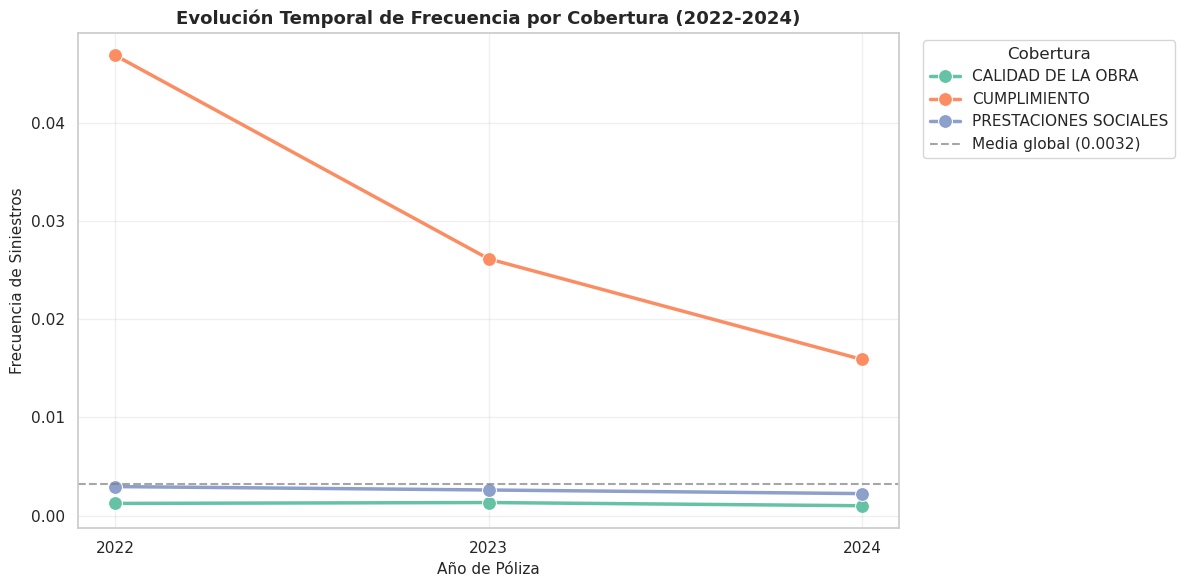


💡 Observaciones:
   → CUMPLIMIENTO mantiene frecuencia consistentemente más alta
   → Las frecuencias son relativamente estables en el período
   → No se observan tendencias marcadas al alza o a la baja


In [39]:
# Gráfica 5.1: Evolución temporal de frecuencia por amparo (2022-2024)

fig, ax = plt.subplots(figsize=(12, 6))



sns.lineplot(data=freq_anual, x='ANIO_POLIZA', y='frecuencia',

             hue='AMPARO', marker='o', palette='Set2', ax=ax, linewidth=2.5, markersize=10)



# Línea de frecuencia global

freq_global = df['TUVO_SINIESTRO'].mean()

ax.axhline(y=freq_global, color='gray', linestyle='--', alpha=0.7, 

           linewidth=1.5, label=f'Media global ({freq_global:.4f})')



ax.set_xlabel('Año de Póliza', fontsize=11)

ax.set_ylabel('Frecuencia de Siniestros', fontsize=11)

ax.set_title('Evolución Temporal de Frecuencia por Cobertura (2022-2024)', fontsize=13, fontweight='bold')

ax.legend(title='Cobertura', bbox_to_anchor=(1.02, 1), loc='upper left')

ax.grid(True, alpha=0.3)

ax.set_xticks([2022, 2023, 2024])



plt.tight_layout()

plt.savefig('../images/fase10_evolucion_temporal.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Observaciones:")

print("   → CUMPLIMIENTO mantiene frecuencia consistentemente más alta")

print("   → Las frecuencias son relativamente estables en el período")

print("   → No se observan tendencias marcadas al alza o a la baja")


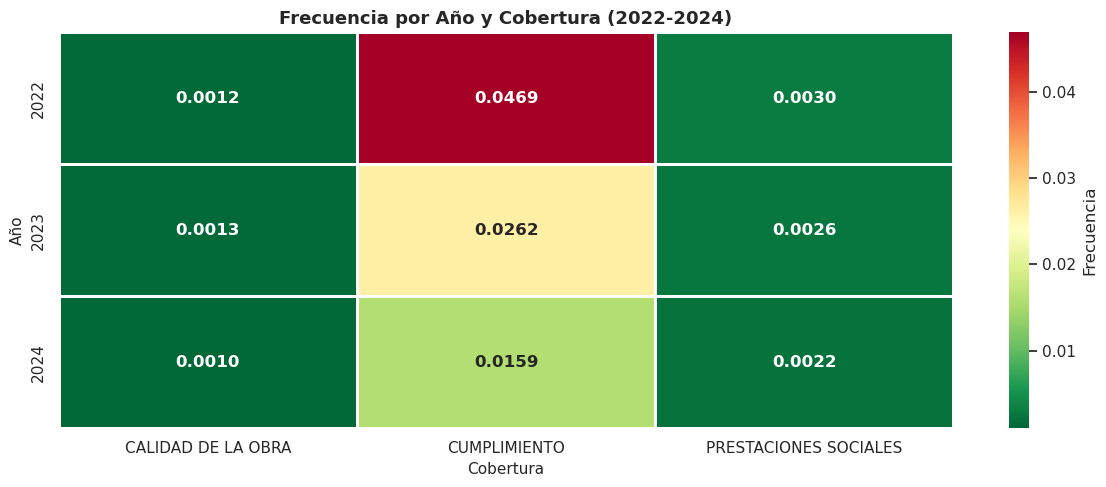


💡 Interpretación del heatmap:
   → Colores más oscuros (rojos) = mayor frecuencia
   → CUMPLIMIENTO consistentemente más alto en los 3 años
   → CALIDAD DE LA OBRA y PRESTACIONES SOCIALES con frecuencias bajas
   → Patrón estable que permite modelación confiable


In [40]:
# Gráfica 5.2: Heatmap de frecuencia año × amparo (2022-2024)

pivot_temporal = freq_anual.pivot(index='ANIO_POLIZA', columns='AMPARO', values='frecuencia')



fig, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(pivot_temporal, annot=True, fmt='.4f', cmap='RdYlGn_r',

            ax=ax, cbar_kws={'label': 'Frecuencia'}, linewidths=1,

            annot_kws={'size': 12, 'fontweight': 'bold'})

ax.set_title('Frecuencia por Año y Cobertura (2022-2024)', fontsize=13, fontweight='bold')

ax.set_xlabel('Cobertura', fontsize=11)

ax.set_ylabel('Año', fontsize=11)



plt.tight_layout()

plt.savefig('../images/fase10_heatmap_anio_amparo.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Interpretación del heatmap:")

print("   → Colores más oscuros (rojos) = mayor frecuencia")

print("   → CUMPLIMIENTO consistentemente más alto en los 3 años")

print("   → CALIDAD DE LA OBRA y PRESTACIONES SOCIALES con frecuencias bajas")

print("   → Patrón estable que permite modelación confiable")


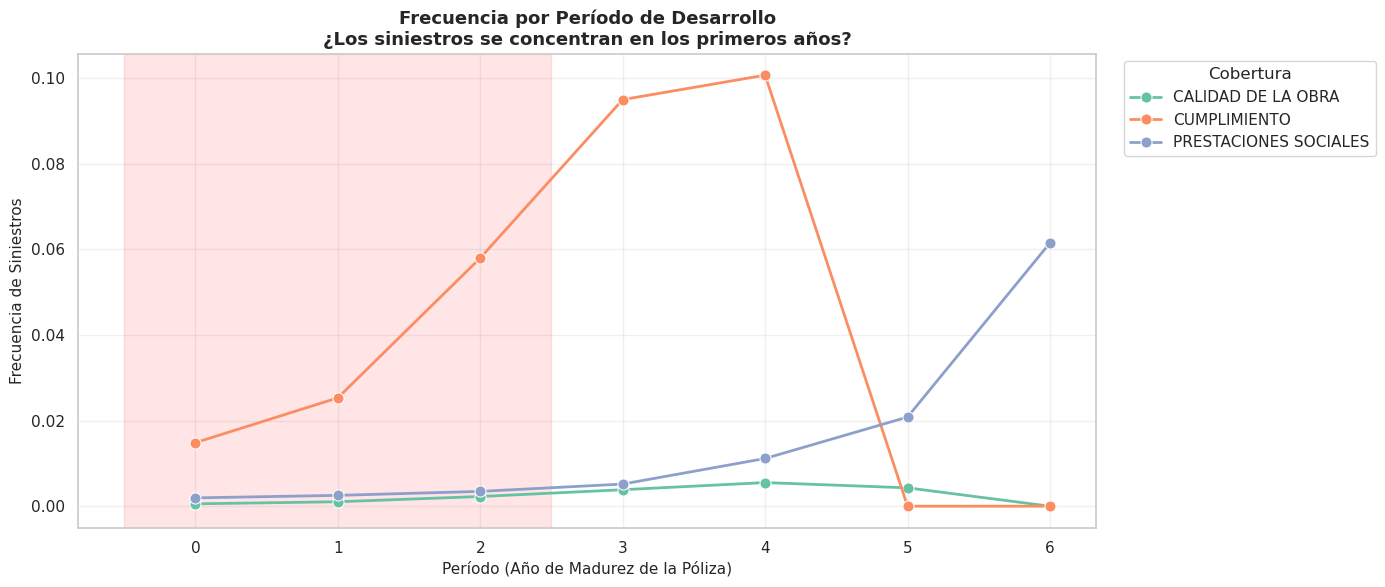


💡 Análisis de desarrollo:
   → En pólizas de cumplimiento, los siniestros suelen concentrarse
     en los primeros años de vigencia (período 0-2)
   → Esto refleja el ciclo de vida del contrato subyacente
   → Períodos posteriores tienen menor exposición y frecuencia


In [41]:
# Gráfica 5.3: Frecuencia por PERIODO (desarrollo/madurez de la póliza)

freq_periodo = df.groupby(['PERIODO', 'AMPARO']).agg(

    n_expuestos=('TUVO_SINIESTRO', 'count'),

    n_siniestros=('TUVO_SINIESTRO', 'sum')

).reset_index()

freq_periodo['frecuencia'] = freq_periodo['n_siniestros'] / freq_periodo['n_expuestos']



# Filtrar períodos con suficiente exposición

periodos_validos = freq_periodo.groupby('PERIODO')['n_expuestos'].sum()

periodos_validos = periodos_validos[periodos_validos >= 50].index

freq_periodo = freq_periodo[freq_periodo['PERIODO'].isin(periodos_validos)]



fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(data=freq_periodo, x='PERIODO', y='frecuencia',

             hue='AMPARO', marker='o', palette='Set2', ax=ax, linewidth=2, markersize=8)



ax.set_xlabel('Período (Año de Madurez de la Póliza)', fontsize=11)

ax.set_ylabel('Frecuencia de Siniestros', fontsize=11)

ax.set_title('Frecuencia por Período de Desarrollo\n¿Los siniestros se concentran en los primeros años?', 

             fontsize=13, fontweight='bold')

ax.legend(title='Cobertura', bbox_to_anchor=(1.02, 1), loc='upper left')

ax.grid(True, alpha=0.3)



# Añadir zona de período 0-2 (crítico)

ax.axvspan(-0.5, 2.5, alpha=0.1, color='red', label='Zona crítica (0-2)')



plt.tight_layout()

plt.savefig('../images/fase10_frecuencia_por_periodo.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Análisis de desarrollo:")

print("   → En pólizas de cumplimiento, los siniestros suelen concentrarse")

print("     en los primeros años de vigencia (período 0-2)")

print("   → Esto refleja el ciclo de vida del contrato subyacente")

print("   → Períodos posteriores tienen menor exposición y frecuencia")


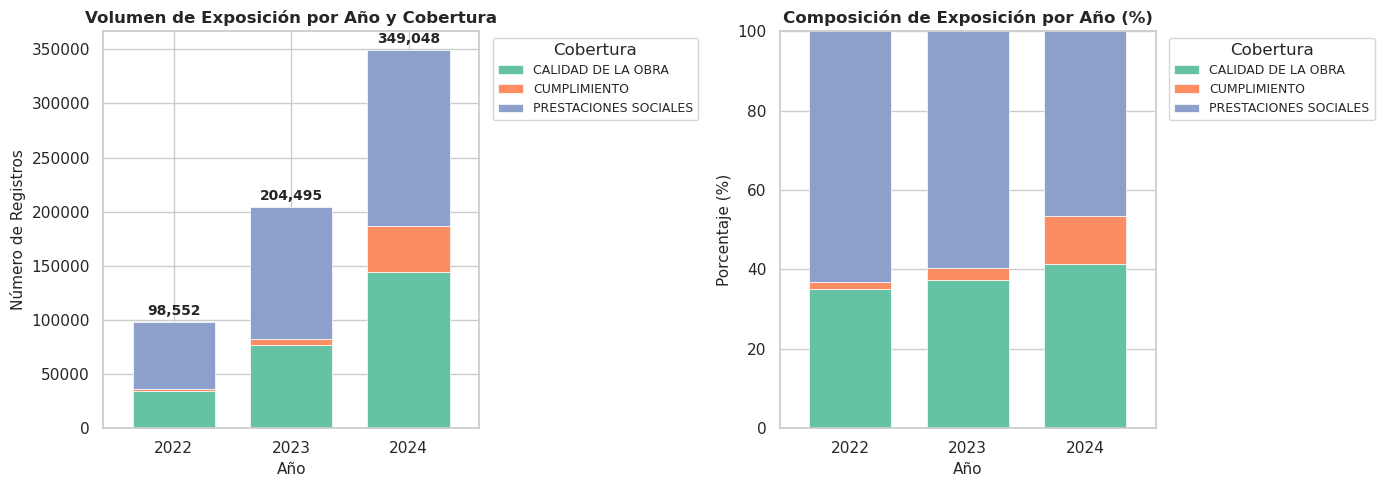


💡 Análisis de volumen (2022-2024):
   → Crecimiento sostenido del volumen de negocio
   → La composición entre coberturas es estable
   → PRESTACIONES SOCIALES y CALIDAD DE LA OBRA dominan en volumen
   → CUMPLIMIENTO tiene alta frecuencia de siniestros pese a menor exposición


In [42]:
# Gráfica 5.4: Volumen de exposición por año y cobertura (2022-2024)
vol_anual = df.groupby(['ANIO_POLIZA', 'AMPARO']).size().reset_index(name='n_registros')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n_amparos = df['AMPARO'].nunique()

# Gráfico 1: Barras apiladas
pivot_vol = vol_anual.pivot(index='ANIO_POLIZA', columns='AMPARO', values='n_registros').fillna(0)
pivot_vol.plot(kind='bar', stacked=True, ax=axes[0], color=sns.color_palette('Set2', n_colors=n_amparos),
               edgecolor='white', linewidth=0.5, width=0.7)
axes[0].set_xlabel('Año', fontsize=11)
axes[0].set_ylabel('Número de Registros', fontsize=11)
axes[0].set_title('Volumen de Exposición por Año y Cobertura', fontsize=12, fontweight='bold')
axes[0].legend(title='Cobertura', bbox_to_anchor=(1.02, 1), fontsize=9)
axes[0].tick_params(axis='x', rotation=0)

# Añadir totales encima de cada barra
totales = pivot_vol.sum(axis=1)
for i, (idx, total) in enumerate(totales.items()):
    axes[0].annotate(f'{int(total):,}', (i, total), textcoords="offset points",
                    xytext=(0, 5), ha='center', fontsize=10, fontweight='bold')

# Gráfico 2: Composición porcentual
pivot_vol_pct = pivot_vol.div(pivot_vol.sum(axis=1), axis=0) * 100
pivot_vol_pct.plot(kind='bar', stacked=True, ax=axes[1], color=sns.color_palette('Set2', n_colors=n_amparos),
                   edgecolor='white', linewidth=0.5, width=0.7)
axes[1].set_xlabel('Año', fontsize=11)
axes[1].set_ylabel('Porcentaje (%)', fontsize=11)
axes[1].set_title('Composición de Exposición por Año (%)', fontsize=12, fontweight='bold')
axes[1].legend(title='Cobertura', bbox_to_anchor=(1.02, 1), fontsize=9)
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.savefig('../images/fase10_volumen_anual.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Análisis de volumen (2022-2024):")
print("   → Crecimiento sostenido del volumen de negocio")
print("   → La composición entre coberturas es estable")
print("   → PRESTACIONES SOCIALES y CALIDAD DE LA OBRA dominan en volumen")
print("   → CUMPLIMIENTO tiene alta frecuencia de siniestros pese a menor exposición")

## Fase 11: Validación del Clustering de Amparos

**Objetivo**: Validar que el clustering de 15 amparos originales a 3 grupos agrupa coberturas con comportamiento similar.

**Variables analizadas**:
- `AMPARO`: Cobertura clustered (3 categorías)
- `AMPARO_ORIGINAL`: Cobertura original (15 categorías)

**Nota**: DISPOSICIONES LEGALES fue combinado con CUMPLIMIENTO por baja credibilidad (solo 6 siniestros).

In [43]:
# ═══════════════════════════════════════════════════════════════════════════════
# FASE 9: VALIDACIÓN DEL CLUSTERING DE AMPAROS
# ═══════════════════════════════════════════════════════════════════════════════

# Gráfica 9.1: Tabla cruzada AMPARO vs AMPARO_ORIGINAL
print("═" * 70)
print("MAPEO DEL CLUSTERING: AMPARO_ORIGINAL → AMPARO (CLUSTERED)")
print("═" * 70)

# Crear tabla cruzada
tabla_cruzada = pd.crosstab(df['AMPARO_ORIGINAL'], df['AMPARO'], margins=True, margins_name='Total')
print("\nDistribución de registros:")
print(tabla_cruzada.to_string())

# Calcular frecuencias por amparo original
freq_original = df.groupby('AMPARO_ORIGINAL').agg(
    n_registros=('TUVO_SINIESTRO', 'count'),
    n_siniestros=('TUVO_SINIESTRO', 'sum'),
    exposicion_total=('FRACCION_ANUAL', 'sum')
).reset_index()

freq_original['frecuencia'] = freq_original['n_siniestros'] / freq_original['exposicion_total']

# Agregar cluster al que pertenece
mapeo_cluster = df.groupby('AMPARO_ORIGINAL')['AMPARO'].first().reset_index()
mapeo_cluster.columns = ['AMPARO_ORIGINAL', 'CLUSTER']
freq_original = freq_original.merge(mapeo_cluster, on='AMPARO_ORIGINAL')

# Ordenar por frecuencia
freq_original = freq_original.sort_values('frecuencia', ascending=False)

print("\n" + "═" * 70)
print("FRECUENCIAS POR AMPARO ORIGINAL (15 CATEGORÍAS)")
print("═" * 70)
print(f"{'AMPARO ORIGINAL':<35} {'CLUSTER':<25} {'FREC':>10} {'N_REG':>10} {'N_SIN':>8}")
print("-" * 100)
for _, row in freq_original.iterrows():
    print(f"{row['AMPARO_ORIGINAL']:<35} {row['CLUSTER']:<25} {row['frecuencia']:>10.4f} {row['n_registros']:>10,} {row['n_siniestros']:>8,}")

══════════════════════════════════════════════════════════════════════
MAPEO DEL CLUSTERING: AMPARO_ORIGINAL → AMPARO (CLUSTERED)
══════════════════════════════════════════════════════════════════════

Distribución de registros:
AMPARO                             CALIDAD DE LA OBRA  CUMPLIMIENTO  PRESTACIONES SOCIALES   Total
AMPARO_ORIGINAL                                                                                   
BUEN MANEJO DE MATERIALES                         103             0                      0     103
BUEN MANEJO DEL ANTICIPO                            0          4492                      0    4492
CALIDAD                                         12323             0                      0   12323
CALIDAD DE LOS ELEMENTOS                        27860             0                      0   27860
CALIDAD DEL SERVICIO                            80017             0                      0   80017
CALIDAD Y CORRECTO FUNCIONAMIENTO               18569             0           

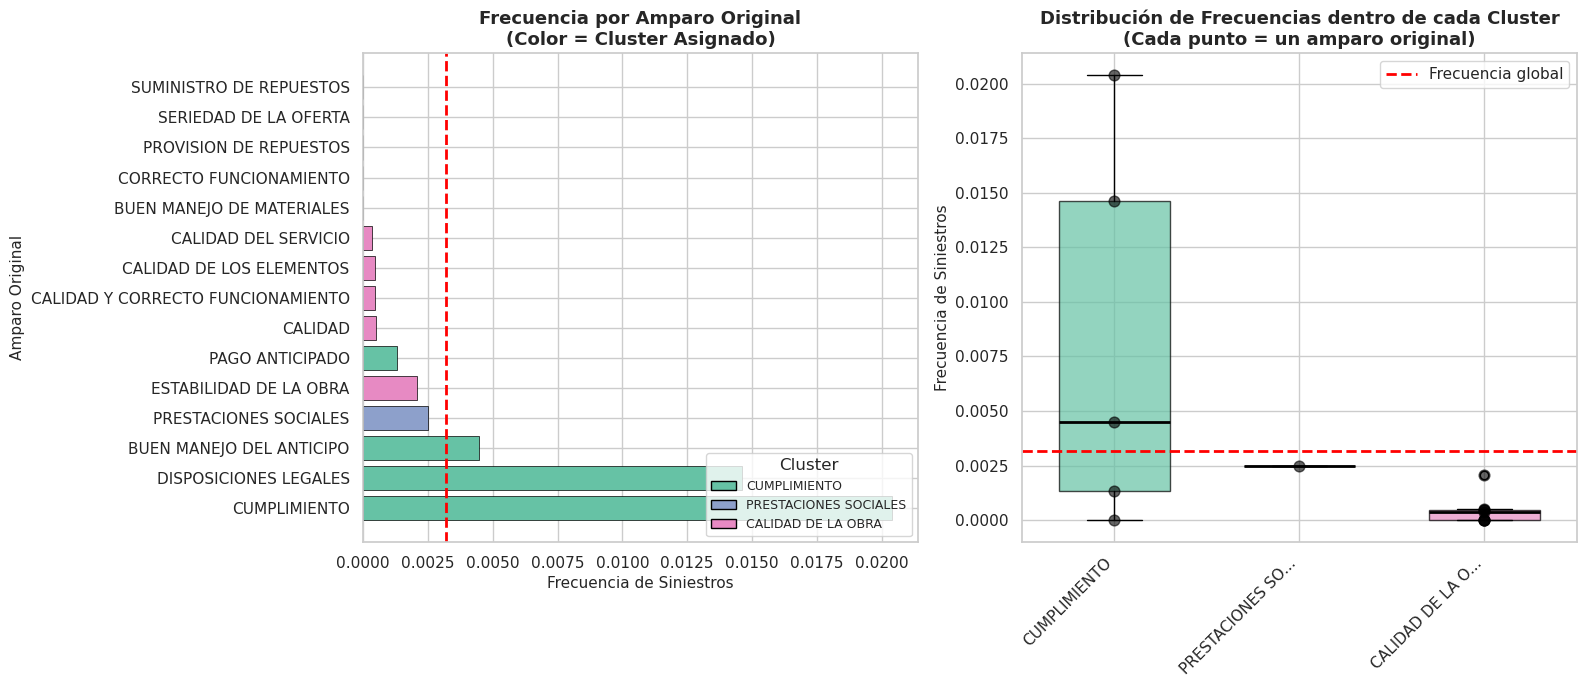


══════════════════════════════════════════════════════════════════════
VALIDACIÓN DEL CLUSTERING (3 GRUPOS)
══════════════════════════════════════════════════════════════════════

CUMPLIMIENTO:
   → Amparos originales: 5
   → Frecuencia: 0.0000 - 0.0204 (rango)
   → Frecuencia promedio: 0.0082
   → Coef. Variación: 109.27%
   ⚠ Cluster HETEROGÉNEO (CV ≥ 30%)

PRESTACIONES SOCIALES:
   → Amparos originales: 1
   → Frecuencia: 0.0025 - 0.0025 (rango)
   → Frecuencia promedio: 0.0025
   → CV: N/A (un solo amparo original)

CALIDAD DE LA OBRA:
   → Amparos originales: 9
   → Frecuencia: 0.0000 - 0.0021 (rango)
   → Frecuencia promedio: 0.0004
   → Coef. Variación: 152.39%
   ⚠ Cluster HETEROGÉNEO (CV ≥ 30%)


In [44]:
# Gráfica 9.2 y 9.3: Visualización del clustering
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Gráfico 1: Frecuencias por amparo original, coloreado por cluster
# Solo 3 clusters (DISPOSICIONES LEGALES fue combinado con CUMPLIMIENTO)
colores_cluster = {'CUMPLIMIENTO': '#66c2a5', 
                   'PRESTACIONES SOCIALES': '#8da0cb', 
                   'CALIDAD DE LA OBRA': '#e78ac3'}
colors = [colores_cluster.get(c, '#999999') for c in freq_original['CLUSTER']]

bars = axes[0].barh(freq_original['AMPARO_ORIGINAL'], freq_original['frecuencia'], 
                    color=colors, edgecolor='black', linewidth=0.5)
axes[0].set_xlabel('Frecuencia de Siniestros', fontsize=11)
axes[0].set_ylabel('Amparo Original', fontsize=11)
axes[0].set_title('Frecuencia por Amparo Original\n(Color = Cluster Asignado)', 
                  fontsize=13, fontweight='bold')
axes[0].axvline(x=df['TUVO_SINIESTRO'].mean() / df['FRACCION_ANUAL'].mean(), 
                color='red', linestyle='--', linewidth=2, label='Frecuencia global')

# Crear leyenda de clusters
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=v, edgecolor='black', label=k) 
                   for k, v in colores_cluster.items()]
axes[0].legend(handles=legend_elements, title='Cluster', loc='lower right', fontsize=9)

# Gráfico 2: Boxplot de frecuencias por cluster
freq_box = freq_original.copy()
orden_cluster = ['CUMPLIMIENTO', 'PRESTACIONES SOCIALES', 'CALIDAD DE LA OBRA']

ax2 = axes[1]
for i, cluster in enumerate(orden_cluster):
    datos = freq_box[freq_box['CLUSTER'] == cluster]['frecuencia'].values
    if len(datos) > 0:
        bp = ax2.boxplot([datos], positions=[i], widths=0.6,
                         patch_artist=True, 
                         boxprops=dict(facecolor=colores_cluster[cluster], alpha=0.7),
                         medianprops=dict(color='black', linewidth=2))
        # Agregar puntos individuales
        ax2.scatter([i]*len(datos), datos, color='black', alpha=0.6, s=60, zorder=3)
    
ax2.set_xticks(range(len(orden_cluster)))
ax2.set_xticklabels([c[:15] + '...' if len(c) > 15 else c for c in orden_cluster], rotation=45, ha='right')
ax2.set_ylabel('Frecuencia de Siniestros', fontsize=11)
ax2.set_title('Distribución de Frecuencias dentro de cada Cluster\n(Cada punto = un amparo original)', 
              fontsize=13, fontweight='bold')
ax2.axhline(y=df['TUVO_SINIESTRO'].mean() / df['FRACCION_ANUAL'].mean(), 
            color='red', linestyle='--', linewidth=2, label='Frecuencia global')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('../images/fase11_validacion_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

# Análisis de coherencia del clustering
print("\n" + "═" * 70)
print("VALIDACIÓN DEL CLUSTERING (3 GRUPOS)")
print("═" * 70)

for cluster in orden_cluster:
    amparos_cluster = freq_original[freq_original['CLUSTER'] == cluster]
    if len(amparos_cluster) > 0:
        freq_min = amparos_cluster['frecuencia'].min()
        freq_max = amparos_cluster['frecuencia'].max()
        freq_mean = amparos_cluster['frecuencia'].mean()
        cv = amparos_cluster['frecuencia'].std() / freq_mean if freq_mean > 0 and len(amparos_cluster) > 1 else 0
        
        print(f"\n{cluster}:")
        print(f"   → Amparos originales: {len(amparos_cluster)}")
        print(f"   → Frecuencia: {freq_min:.4f} - {freq_max:.4f} (rango)")
        print(f"   → Frecuencia promedio: {freq_mean:.4f}")
        if len(amparos_cluster) > 1:
            print(f"   → Coef. Variación: {cv:.2%}")
            if cv < 0.3:
                print(f"   ✓ Cluster HOMOGÉNEO (CV < 30%)")
            else:
                print(f"   ⚠ Cluster HETEROGÉNEO (CV ≥ 30%)")
        else:
            print(f"   → CV: N/A (un solo amparo original)")

## Fase 12: Análisis Estacional de Siniestros

**Objetivo**: Identificar patrones estacionales en la ocurrencia de siniestros.

**Variable analizada**: `FECHA_DE_SINIESTRO` (solo registros con siniestro)

**Nota**: Este análisis solo incluye los registros que efectivamente tuvieron siniestro.

In [45]:
# ═══════════════════════════════════════════════════════════════════════════════
# FASE 10: ANÁLISIS ESTACIONAL DE SINIESTROS
# ═══════════════════════════════════════════════════════════════════════════════

# Filtrar solo registros con siniestro y fecha válida
df_siniestros = df[df['TUVO_SINIESTRO'] == 1].copy()
df_siniestros['FECHA_DE_SINIESTRO'] = pd.to_datetime(df_siniestros['FECHA_DE_SINIESTRO'], errors='coerce')
df_siniestros = df_siniestros.dropna(subset=['FECHA_DE_SINIESTRO'])

# Extraer componentes temporales
df_siniestros['MES'] = df_siniestros['FECHA_DE_SINIESTRO'].dt.month
df_siniestros['TRIMESTRE'] = df_siniestros['FECHA_DE_SINIESTRO'].dt.quarter
df_siniestros['DIA_SEMANA'] = df_siniestros['FECHA_DE_SINIESTRO'].dt.dayofweek
df_siniestros['AÑO_SINIESTRO'] = df_siniestros['FECHA_DE_SINIESTRO'].dt.year

print("═" * 70)
print("ANÁLISIS ESTACIONAL DE SINIESTROS")
print("═" * 70)
print(f"Siniestros con fecha válida: {len(df_siniestros):,}")
print(f"Período de fechas: {df_siniestros['FECHA_DE_SINIESTRO'].min().date()} a {df_siniestros['FECHA_DE_SINIESTRO'].max().date()}")

# Resumen por mes
print("\n" + "-" * 50)
print("Distribución por MES:")
meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
siniestros_mes = df_siniestros['MES'].value_counts().sort_index()
for mes, count in siniestros_mes.items():
    barra = '█' * int(count / siniestros_mes.max() * 30)
    print(f"   {meses[mes-1]:>3}: {count:>5} {barra}")

══════════════════════════════════════════════════════════════════════
ANÁLISIS ESTACIONAL DE SINIESTROS
══════════════════════════════════════════════════════════════════════
Siniestros con fecha válida: 2,078
Período de fechas: 2008-09-02 a 2025-06-13

--------------------------------------------------
Distribución por MES:
   Ene:   138 █████████████████
   Feb:   165 █████████████████████
   Mar:   191 ████████████████████████
   Abr:   189 ████████████████████████
   May:   174 ██████████████████████
   Jun:   169 █████████████████████
   Jul:   208 ██████████████████████████
   Ago:   144 ██████████████████
   Sep:   140 ██████████████████
   Oct:   153 ███████████████████
   Nov:   175 ██████████████████████
   Dic:   232 ██████████████████████████████


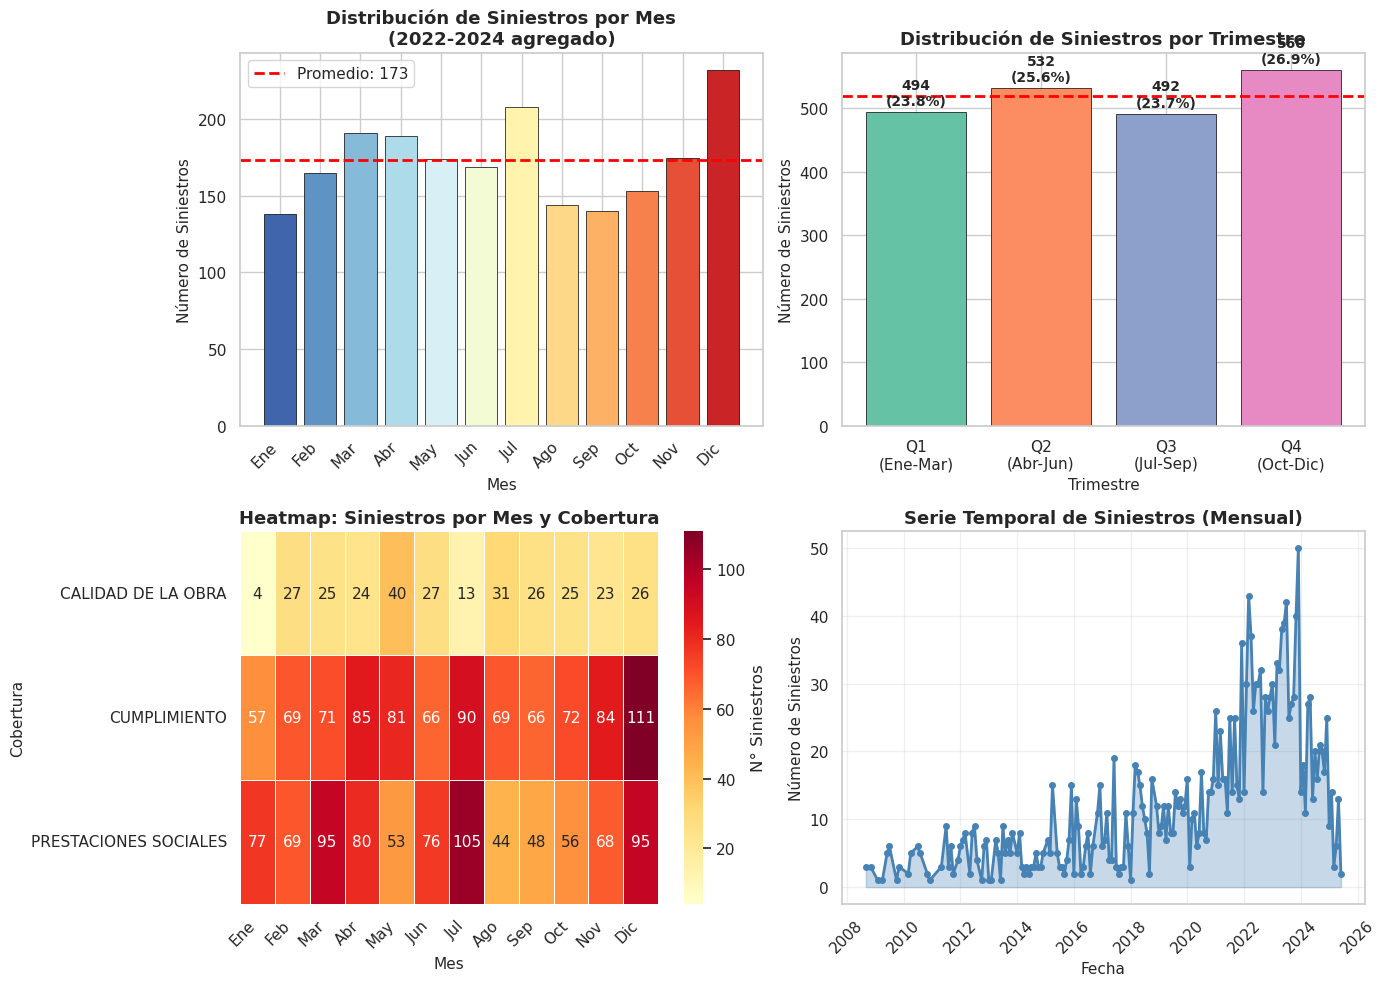


💡 Análisis estacional:
   → Mes con más siniestros: Dic (232)
   → Mes con menos siniestros: Ene (138)
   → Ratio máx/mín: 1.68x


In [46]:
# Gráfica 10.1 y 10.2: Patrones estacionales

fig, axes = plt.subplots(2, 2, figsize=(14, 10))



# Gráfico 1: Siniestros por mes (todos los años agregados)

siniestros_mes = df_siniestros.groupby('MES').size()

meses_nombres = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']



ax1 = axes[0, 0]

colors_mes = sns.color_palette("RdYlBu_r", 12)

bars = ax1.bar(range(1, 13), siniestros_mes, color=colors_mes, edgecolor='black', linewidth=0.5)

ax1.set_xticks(range(1, 13))

ax1.set_xticklabels(meses_nombres, rotation=45, ha='right')

ax1.set_xlabel('Mes', fontsize=11)

ax1.set_ylabel('Número de Siniestros', fontsize=11)

ax1.set_title('Distribución de Siniestros por Mes\n(2022-2024 agregado)', fontsize=13, fontweight='bold')

ax1.axhline(y=siniestros_mes.mean(), color='red', linestyle='--', linewidth=2, label=f'Promedio: {siniestros_mes.mean():.0f}')

ax1.legend()



# Gráfico 2: Siniestros por trimestre

siniestros_trim = df_siniestros.groupby('TRIMESTRE').size()

trimestres = ['Q1\n(Ene-Mar)', 'Q2\n(Abr-Jun)', 'Q3\n(Jul-Sep)', 'Q4\n(Oct-Dic)']



ax2 = axes[0, 1]

colors_trim = sns.color_palette("Set2", 4)

ax2.bar(range(1, 5), siniestros_trim, color=colors_trim, edgecolor='black', linewidth=0.5)

ax2.set_xticks(range(1, 5))

ax2.set_xticklabels(trimestres)

ax2.set_xlabel('Trimestre', fontsize=11)

ax2.set_ylabel('Número de Siniestros', fontsize=11)

ax2.set_title('Distribución de Siniestros por Trimestre', fontsize=13, fontweight='bold')

ax2.axhline(y=siniestros_trim.mean(), color='red', linestyle='--', linewidth=2)



# Agregar etiquetas de porcentaje

total_sin = siniestros_trim.sum()

for i, v in enumerate(siniestros_trim):

    ax2.annotate(f'{v:,}\n({v/total_sin*100:.1f}%)', (i+1, v), textcoords="offset points",

                 xytext=(0, 5), ha='center', fontsize=10, fontweight='bold')



# Gráfico 3: Heatmap Mes × Amparo

sin_mes_amparo = df_siniestros.groupby(['MES', 'AMPARO']).size().unstack(fill_value=0)



ax3 = axes[1, 0]

sns.heatmap(sin_mes_amparo.T, annot=True, fmt='d', cmap='YlOrRd', 

            linewidths=0.5, ax=ax3, cbar_kws={'label': 'N° Siniestros'})

ax3.set_xticklabels(meses_nombres, rotation=45, ha='right')

ax3.set_xlabel('Mes', fontsize=11)

ax3.set_ylabel('Cobertura', fontsize=11)

ax3.set_title('Heatmap: Siniestros por Mes y Cobertura', fontsize=13, fontweight='bold')



# Gráfico 4: Serie temporal mensual

sin_mensual = df_siniestros.groupby(df_siniestros['FECHA_DE_SINIESTRO'].dt.to_period('M')).size()

sin_mensual.index = sin_mensual.index.to_timestamp()



ax4 = axes[1, 1]

ax4.plot(sin_mensual.index, sin_mensual.values, marker='o', linewidth=2, color='steelblue', markersize=4)

ax4.fill_between(sin_mensual.index, sin_mensual.values, alpha=0.3, color='steelblue')

ax4.set_xlabel('Fecha', fontsize=11)

ax4.set_ylabel('Número de Siniestros', fontsize=11)

ax4.set_title('Serie Temporal de Siniestros (Mensual)', fontsize=13, fontweight='bold')

ax4.tick_params(axis='x', rotation=45)

ax4.grid(True, alpha=0.3)



plt.tight_layout()

plt.savefig('../images/fase12_patrones_estacionales.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Análisis estacional:")

mes_max = siniestros_mes.idxmax()

mes_min = siniestros_mes.idxmin()

print(f"   → Mes con más siniestros: {meses_nombres[mes_max-1]} ({siniestros_mes[mes_max]:,})")

print(f"   → Mes con menos siniestros: {meses_nombres[mes_min-1]} ({siniestros_mes[mes_min]:,})")

print(f"   → Ratio máx/mín: {siniestros_mes.max()/siniestros_mes.min():.2f}x")


## Fase 13: Tests de Sobredispersión

**Objetivo**: Determinar si un modelo Poisson es apropiado o si necesitamos Binomial Negativa debido a sobredispersión

In [47]:
# Agregación a nivel póliza-amparo para análisis de conteos
df_poliza = df.groupby(['POLIZA', 'AMPARO']).agg(
    n_periodos=('PERIODO', 'count'),
    total_siniestros=('TUVO_SINIESTRO', 'sum'),
    exposicion_total=('FRACCION_ANUAL', 'sum')
).reset_index()

print("=" * 70)
print("ANÁLISIS DE SOBREDISPERSIÓN")
print("=" * 70)
print("\nEn un modelo Poisson, la varianza debe ser igual a la media.")
print("Si Var > Media (Índice de Dispersión > 1), hay SOBREDISPERSIÓN.")
print("Esto indica que deberíamos usar Binomial Negativa en lugar de Poisson.")
print("-" * 70)

print("\nÍNDICE DE DISPERSIÓN (Var/Media) por Amparo:")
print(f"\n{'AMPARO':<25} {'MEDIA':>10} {'VARIANZA':>12} {'DISP (V/M)':>12} {'DIAGNÓSTICO':<20}")
print("-" * 80)

diagnosticos = []
for amparo in sorted(df['AMPARO'].unique()):
    data = df_poliza[df_poliza['AMPARO'] == amparo]['total_siniestros']
    media = data.mean()
    varianza = data.var()
    dispersion = varianza / media if media > 0 else np.nan
    
    if dispersion > 1.5:
        diagnostico = "SOBREDISPERSIÓN"
    elif dispersion > 1.1:
        diagnostico = "Leve sobredispersión"
    else:
        diagnostico = "≈ Poisson OK"
    
    diagnosticos.append({
        'AMPARO': amparo, 'media': media, 'varianza': varianza, 
        'dispersion': dispersion, 'diagnostico': diagnostico
    })
    print(f"{amparo:<25} {media:>10.4f} {varianza:>12.4f} {dispersion:>12.2f} {diagnostico:<20}")

df_dispersion = pd.DataFrame(diagnosticos)

ANÁLISIS DE SOBREDISPERSIÓN

En un modelo Poisson, la varianza debe ser igual a la media.
Si Var > Media (Índice de Dispersión > 1), hay SOBREDISPERSIÓN.
Esto indica que deberíamos usar Binomial Negativa en lugar de Poisson.
----------------------------------------------------------------------

ÍNDICE DE DISPERSIÓN (Var/Media) por Amparo:

AMPARO                         MEDIA     VARIANZA   DISP (V/M) DIAGNÓSTICO         
--------------------------------------------------------------------------------
CALIDAD DE LA OBRA            0.0025       0.0055         2.22 SOBREDISPERSIÓN     
CUMPLIMIENTO                  0.0238       0.0394         1.66 SOBREDISPERSIÓN     
PRESTACIONES SOCIALES         0.0051       0.0127         2.50 SOBREDISPERSIÓN     


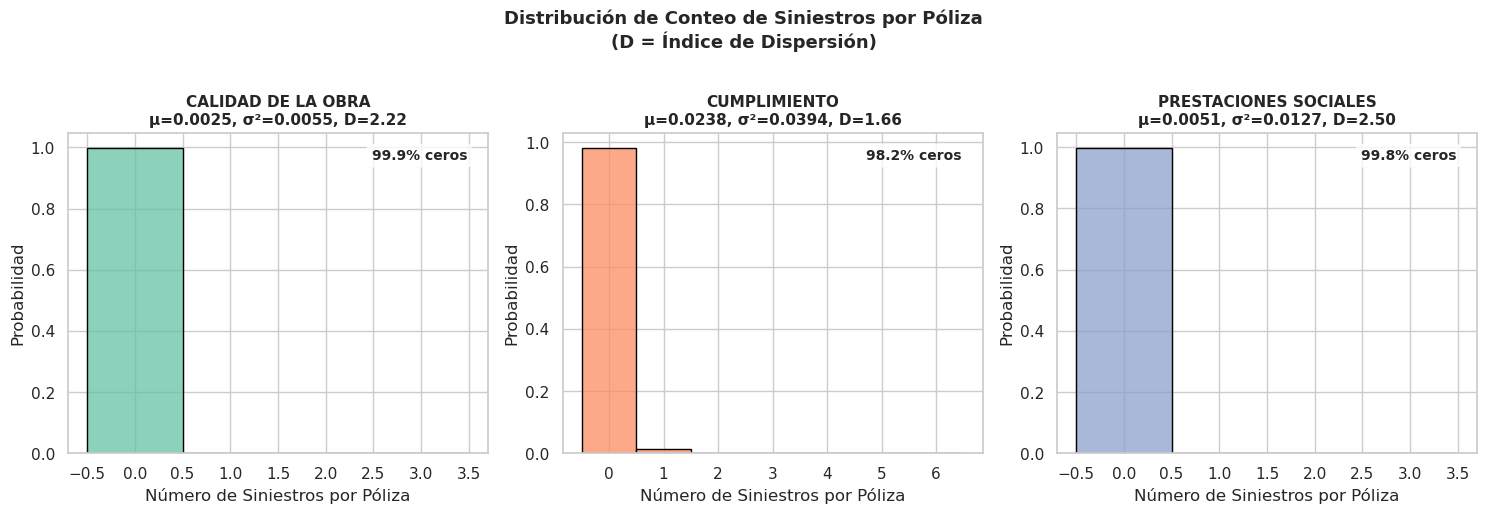


💡 Observaciones:
   → Alta proporción de ceros en todas las coberturas (>90%)
   → Distribuciones muy asimétricas a la derecha
   → Considerar modelos zero-inflated si D >> 1


In [48]:
# Gráfica 6.1: Distribución de conteos de siniestros por póliza
amparos = sorted(df['AMPARO'].unique())
n_amparos = len(amparos)

# Ajustar subplots según número de amparos
n_cols = min(n_amparos, 3)
n_rows = (n_amparos + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
if n_amparos == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_amparos > 1 else [axes]

colors = sns.color_palette('Set2', n_colors=n_amparos)

for idx, amparo in enumerate(amparos):
    ax = axes[idx]
    data = df_poliza[df_poliza['AMPARO'] == amparo]['total_siniestros']
    
    # Histograma de conteos
    max_sin = min(int(data.max()), 10)  # Limitar para visualización
    bins = np.arange(-0.5, max_sin + 1.5, 1)
    
    sns.histplot(data[data <= max_sin], bins=bins, ax=ax, color=colors[idx], 
                 edgecolor='black', stat='probability')
    
    # Estadísticas
    media = data.mean()
    varianza = data.var()
    disp = varianza / media if media > 0 else 0
    
    ax.set_title(f'{amparo}\nμ={media:.4f}, σ²={varianza:.4f}, D={disp:.2f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Número de Siniestros por Póliza')
    ax.set_ylabel('Probabilidad')
    
    # Anotar proporción de ceros
    prop_ceros = (data == 0).mean() * 100
    ax.annotate(f'{prop_ceros:.1f}% ceros', xy=(0.95, 0.95), xycoords='axes fraction',
                ha='right', va='top', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Ocultar ejes vacíos si hay
for idx in range(n_amparos, len(axes)):
    axes[idx].set_visible(False)

plt.suptitle('Distribución de Conteo de Siniestros por Póliza\n(D = Índice de Dispersión)', 
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/fase13_conteos_siniestros.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 Observaciones:")
print("   → Alta proporción de ceros en todas las coberturas (>90%)")
print("   → Distribuciones muy asimétricas a la derecha")
print("   → Considerar modelos zero-inflated si D >> 1")

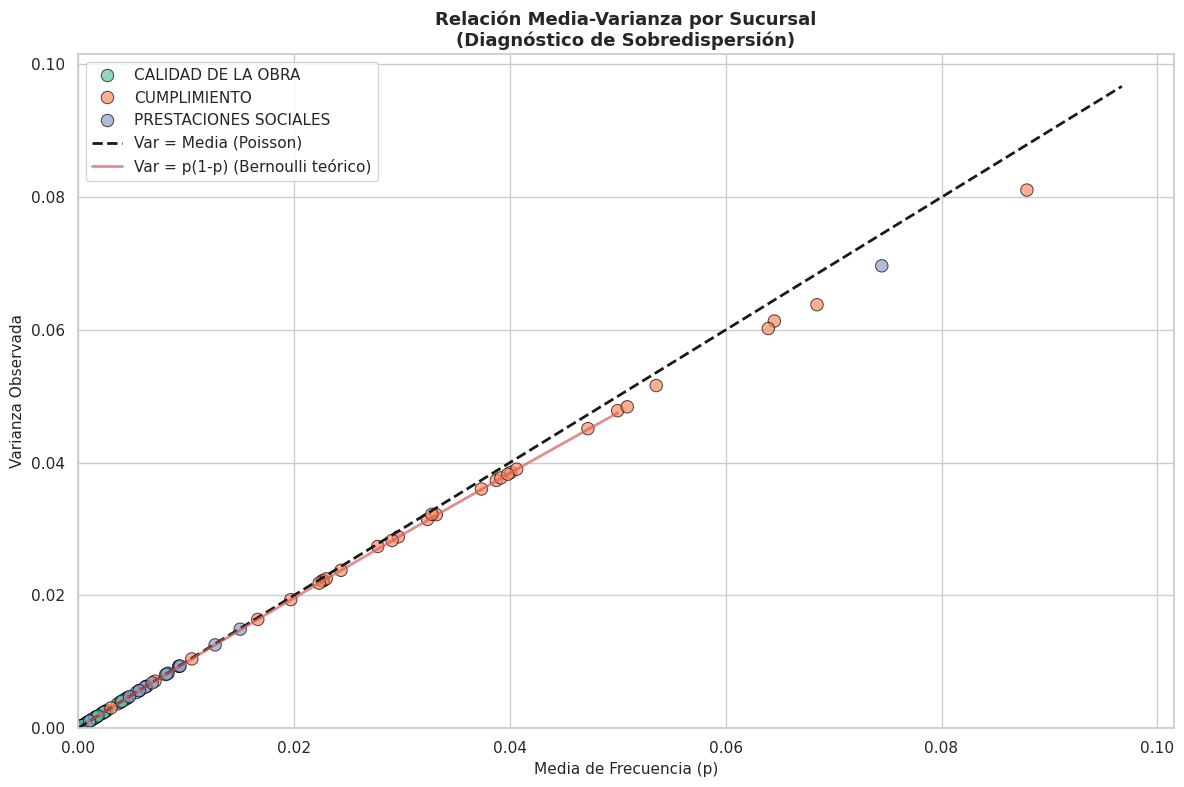


💡 Interpretación:
   → Puntos SOBRE la línea Var=Media indican sobredispersión
   → Para datos Bernoulli, Var = p(1-p) < p siempre
   → Los puntos deberían estar cerca de la curva roja
   → Desviaciones grandes sugieren heterogeneidad no capturada


In [49]:
# Gráfica 6.2: Relación Media-Varianza por sucursal (diagnóstico de Poisson)

stats_sucursal = df.groupby(['COD_SUCURSAL', 'AMPARO']).agg(

    media=('TUVO_SINIESTRO', 'mean'),

    varianza=('TUVO_SINIESTRO', 'var'),

    n=('TUVO_SINIESTRO', 'count')

).reset_index().dropna()



# Filtrar sucursales con suficiente exposición

stats_sucursal = stats_sucursal[stats_sucursal['n'] >= 50]



fig, ax = plt.subplots(figsize=(12, 8))



sns.scatterplot(data=stats_sucursal, x='media', y='varianza',

                hue='AMPARO', palette='Set2', ax=ax, s=80, alpha=0.7, edgecolor='black')



# Línea de equidispersión (Poisson: var = media)

max_val = max(stats_sucursal['media'].max(), stats_sucursal['varianza'].max()) * 1.1

ax.plot([0, max_val], [0, max_val], 'k--', linewidth=2, label='Var = Media (Poisson)')



# Línea de varianza Bernoulli teórica: Var = p(1-p) ≈ p para p pequeño

x_line = np.linspace(0.001, 0.05, 100)

ax.plot(x_line, x_line * (1 - x_line), 'r-', linewidth=2, 

        label='Var = p(1-p) (Bernoulli teórico)', alpha=0.7)



ax.set_xlabel('Media de Frecuencia (p)', fontsize=11)

ax.set_ylabel('Varianza Observada', fontsize=11)

ax.set_title('Relación Media-Varianza por Sucursal\n(Diagnóstico de Sobredispersión)', 

             fontsize=13, fontweight='bold')

ax.legend(loc='upper left')

ax.set_xlim(0, None)

ax.set_ylim(0, None)



plt.tight_layout()

plt.savefig('../images/fase13_media_varianza.png', dpi=150, bbox_inches='tight')
plt.show()



print("\n💡 Interpretación:")

print("   → Puntos SOBRE la línea Var=Media indican sobredispersión")

print("   → Para datos Bernoulli, Var = p(1-p) < p siempre")

print("   → Los puntos deberían estar cerca de la curva roja")

print("   → Desviaciones grandes sugieren heterogeneidad no capturada")


## Fase 14: Resumen para Modelación

**Objetivo**: Sintetizar hallazgos y proponer estrategia de modelación de frecuencias

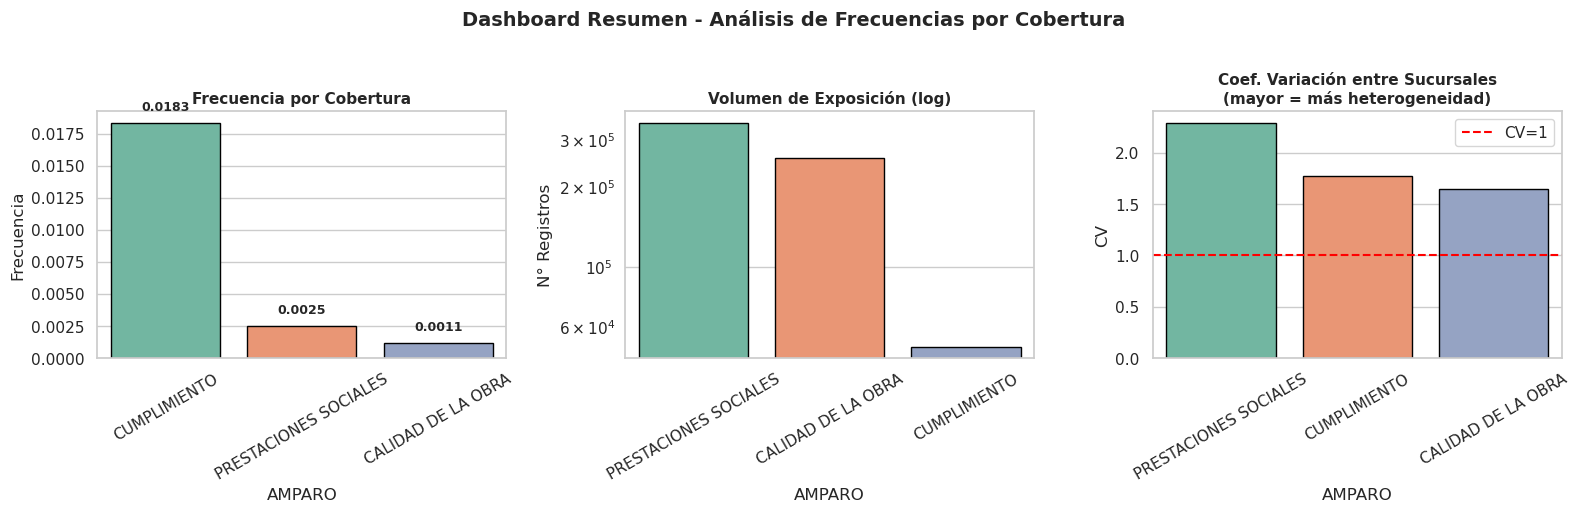

In [50]:
# Gráfica: Dashboard resumen (3 paneles)

resumen = pd.DataFrame({

    'AMPARO': sorted(df['AMPARO'].unique()),

    'frecuencia': [df[df['AMPARO']==a]['TUVO_SINIESTRO'].mean() for a in sorted(df['AMPARO'].unique())],

    'n_expuestos': [len(df[df['AMPARO']==a]) for a in sorted(df['AMPARO'].unique())],

    'n_siniestros': [df[df['AMPARO']==a]['TUVO_SINIESTRO'].sum() for a in sorted(df['AMPARO'].unique())],

    'n_sucursales': [df[df['AMPARO']==a]['COD_SUCURSAL'].nunique() for a in sorted(df['AMPARO'].unique())]

})



# Calcular CV por amparo

cv_sucursal = freq_sucursal.groupby('AMPARO')['frecuencia'].agg(['mean', 'std'])

cv_sucursal['cv'] = cv_sucursal['std'] / cv_sucursal['mean']

cv_sucursal = cv_sucursal.reset_index()



fig, axes = plt.subplots(1, 3, figsize=(16, 5))



# 1. Frecuencias

sns.barplot(data=resumen.sort_values('frecuencia', ascending=False), 

            x='AMPARO', y='frecuencia', palette='Set2', ax=axes[0], edgecolor='black')

axes[0].set_title('Frecuencia por Cobertura', fontsize=11, fontweight='bold')

axes[0].tick_params(axis='x', rotation=30)

axes[0].set_ylabel('Frecuencia')

for i, (amparo, freq) in enumerate(zip(resumen.sort_values('frecuencia', ascending=False)['AMPARO'], 

                                        resumen.sort_values('frecuencia', ascending=False)['frecuencia'])):

    axes[0].text(i, freq + 0.001, f'{freq:.4f}', ha='center', fontsize=9, fontweight='bold')



# 2. Volumen (log scale)

sns.barplot(data=resumen.sort_values('n_expuestos', ascending=False), 

            x='AMPARO', y='n_expuestos', palette='Set2', ax=axes[1], edgecolor='black')

axes[1].set_yscale('log')

axes[1].set_title('Volumen de Exposición (log)', fontsize=11, fontweight='bold')

axes[1].tick_params(axis='x', rotation=30)

axes[1].set_ylabel('N° Registros')



# 3. Heterogeneidad (CV entre sucursales)

cv_sorted = cv_sucursal.sort_values('cv', ascending=False)

sns.barplot(data=cv_sorted, x='AMPARO', y='cv', palette='Set2', ax=axes[2], edgecolor='black')

axes[2].set_title('Coef. Variación entre Sucursales\n(mayor = más heterogeneidad)', fontsize=11, fontweight='bold')

axes[2].tick_params(axis='x', rotation=30)

axes[2].set_ylabel('CV')

axes[2].axhline(y=1.0, color='red', linestyle='--', linewidth=1.5, label='CV=1')

axes[2].legend()



plt.suptitle('Dashboard Resumen - Análisis de Frecuencias por Cobertura', 

             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()

plt.savefig('../images/fase14_dashboard_resumen.png', dpi=150, bbox_inches='tight')
plt.show()


In [51]:
# Tabla resumen final
print("=" * 80)
print("                    RESUMEN DE ANÁLISIS EXPLORATORIO")
print("                    Pólizas de Cumplimiento - Período 2022-2024")
print("=" * 80)

print("\n" + "─" * 80)
print("1. FRECUENCIAS OBSERVADAS POR COBERTURA")
print("─" * 80)
for _, row in resumen.sort_values('frecuencia', ascending=False).iterrows():
    pct = row['frecuencia'] * 100
    print(f"   {row['AMPARO']:<25} → {pct:>6.4f}%  ({row['n_siniestros']:>5,} siniestros / {row['n_expuestos']:>6,} expuestos)")

print("\n" + "─" * 80)
print("2. HETEROGENEIDAD ENTRE SUCURSALES")
print("─" * 80)
for _, row in cv_sucursal.sort_values('cv', ascending=False).iterrows():
    nivel = "ALTA" if row['cv'] > 1.5 else ("MEDIA" if row['cv'] > 0.8 else "BAJA")
    print(f"   {row['AMPARO']:<25} → CV = {row['cv']:.3f} ({nivel})")

print("\n" + "─" * 80)
print("3. SOBREDISPERSIÓN (Poisson vs Binomial Negativa)")
print("─" * 80)
for _, row in df_dispersion.iterrows():
    print(f"   {row['AMPARO']:<25} → D = {row['dispersion']:.2f} ({row['diagnostico']})")

                    RESUMEN DE ANÁLISIS EXPLORATORIO
                    Pólizas de Cumplimiento - Período 2022-2024

────────────────────────────────────────────────────────────────────────────────
1. FRECUENCIAS OBSERVADAS POR COBERTURA
────────────────────────────────────────────────────────────────────────────────
   CUMPLIMIENTO              → 1.8328%  (  921 siniestros / 50,251 expuestos)
   PRESTACIONES SOCIALES     → 0.2502%  (  866 siniestros / 346,128 expuestos)
   CALIDAD DE LA OBRA        → 0.1138%  (  291 siniestros / 255,716 expuestos)

────────────────────────────────────────────────────────────────────────────────
2. HETEROGENEIDAD ENTRE SUCURSALES
────────────────────────────────────────────────────────────────────────────────
   PRESTACIONES SOCIALES     → CV = 2.289 (ALTA)
   CUMPLIMIENTO              → CV = 1.773 (ALTA)
   CALIDAD DE LA OBRA        → CV = 1.652 (ALTA)

────────────────────────────────────────────────────────────────────────────────
3. SOBREDISPERSIÓ

In [52]:
# Exportar estadísticas clave para siguiente fase de modelación
print("=" * 70)
print("EXPORTANDO ARCHIVOS DE RESUMEN")
print("=" * 70)
print(f"\nPeríodo de análisis: 2022-2024")
print(f"Total registros analizados: {len(df):,}")

# 1. Resumen por amparo
resumen_export = resumen.merge(cv_sucursal[['AMPARO', 'cv']], on='AMPARO')
resumen_export = resumen_export.merge(df_dispersion[['AMPARO', 'dispersion', 'diagnostico']], on='AMPARO')
resumen_export['periodo_analisis'] = '2022-2024'
resumen_export.to_csv('../data/tmp/resumen_frecuencias.csv', index=False)
print(f"\n   ✓ ../data/tmp/resumen_frecuencias.csv ({len(resumen_export)} registros)")

# 2. Frecuencias por sucursal
freq_sucursal['periodo_analisis'] = '2022-2024'
freq_sucursal.to_csv('../data/tmp/frecuencias_por_sucursal.csv', index=False)
print(f"   ✓ ../data/tmp/frecuencias_por_sucursal.csv ({len(freq_sucursal)} registros)")

# 3. Frecuencias anuales
freq_anual['periodo_analisis'] = '2022-2024'
freq_anual.to_csv('../data/tmp/frecuencias_anuales.csv', index=False)
print(f"   ✓ ../data/tmp/frecuencias_anuales.csv ({len(freq_anual)} registros)")

print("\n" + "=" * 70)
print("ANÁLISIS EXPLORATORIO COMPLETADO")
print("=" * 70)

EXPORTANDO ARCHIVOS DE RESUMEN

Período de análisis: 2022-2024
Total registros analizados: 652,095

   ✓ ../data/tmp/resumen_frecuencias.csv (3 registros)
   ✓ ../data/tmp/frecuencias_por_sucursal.csv (130 registros)
   ✓ ../data/tmp/frecuencias_anuales.csv (9 registros)

ANÁLISIS EXPLORATORIO COMPLETADO
